Start with baseline CNN inspired by LeNet-5. For this initial investigation, I want to visualize the improvements without considering any domain shifts. I will use the Canine Lymphoma, 3D Histech, VMU Vienna dataset (because it is the largest annotation set).

In [1]:
# Code adapted from Machine Learning Engineering (Cornell Tech 2025)
import torch
import numpy as np
import random

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [2]:
from google.colab import drive
import sys
import os

# --- 1. Mount Drive ---
drive.mount('/content/drive')

# --- 2. Define Paths ---
# Path to the source code (loaders.py) - REMAINS ON DRIVE
DRIVE_CODE_PATH = '/content/drive/MyDrive/GoogleColab/dataformidogcnn/'

# Path to the zipped data file on Drive
ZIP_SOURCE_PATH = os.path.join(DRIVE_CODE_PATH, 'cropped_images.zip')

# Local disk folder where the FAST images will be unzipped
FAST_DATA_PATH = '/content/fast_data/'

# --- 3. Unzip Data (Performance Fix) ---
if not os.path.exists(FAST_DATA_PATH):
    print(f"🚀 Unzipping data from Drive to fast local disk: {FAST_DATA_PATH}")
    !mkdir -p "$FAST_DATA_PATH"
    # The -q flag silences the output. -d sets the destination directory.
    !unzip -q "$ZIP_SOURCE_PATH" -d "$FAST_DATA_PATH"

    print("✅ Data transfer complete. Starting new batch load test.")
else:
    print("Fast data directory already exists.")


# --- 4. Set Final Variables ---
# PROJECT_DIR for the rest of your notebook now points to the FAST images
PROJECT_DIR = FAST_DATA_PATH

# Add the Drive path for Python to find 'loaders.py' and other modules
if DRIVE_CODE_PATH not in sys.path:
    sys.path.append(DRIVE_CODE_PATH)
    print(f"✅ Added {DRIVE_CODE_PATH} to Python system path.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🚀 Unzipping data from Drive to fast local disk: /content/fast_data/
✅ Data transfer complete. Starting new batch load test.
✅ Added /content/drive/MyDrive/GoogleColab/dataformidogcnn/ to Python system path.


In [4]:
import pandas as pd
from loaders import create_loaders # This should now work

# Define the full path to your CSV file
CSV_PATH = os.path.join('/content/drive/MyDrive/GoogleColab/dataformidogcnn/', 'processed_annotations_with_patch_id.csv')

# Load the DataFrame and create the df_master variable
try:
    df_master = pd.read_csv(CSV_PATH)
    print(f"✅ df_master loaded successfully. Total rows: {len(df_master)}")
except FileNotFoundError:
    print(f"❌ CRITICAL ERROR: File not found at {CSV_PATH}. Execution stopping here.")
    df_master = None # Prevent NameError in next cell if failed

✅ df_master loaded successfully. Total rows: 26286


In [28]:
import torchvision.transforms as transforms

TARGET_SIZE = 50

# --- Define Your Full Transformation Pipeline ---
custom_transforms = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE), # <-- 60x60 -> 50x50 Crop
    transforms.ToTensor(),
])

custom_filter = {
    'Tumor': 'canine lymphoma',
    'Scanner': '3D Histech',
    'Origin': 'VMU Vienna'
}

# -------------------------------------------------------------

# Call create_loaders, passing the custom pipeline
IMAGE_PATCH_DIR = PROJECT_DIR
# IMAGE_PATCH_DIR now equals '/content/fast_data/cropped_images'

# -------------------------------------------------------------

# Call create_loaders, passing the corrected image patch path
train_loader, val_loader, test_loader = create_loaders(
    df_master,
    patch_dir=IMAGE_PATCH_DIR, # <--- CORRECTED PATH HERE!
    filters=custom_filter,
    transform=custom_transforms
)

print(f"✅ DataLoaders created, pointing to image directory: {IMAGE_PATCH_DIR}")
#

Applying filters: {'Tumor': 'canine lymphoma', 'Scanner': '3D Histech', 'Origin': 'VMU Vienna'}
Original size: 26286. Filtered size: 8216.

--- Data Split Summary ---
Original Total Annotations: 8216
Train Annotations: 5750 (70.0%)
Validation Annotations: 1233 (15.0%)
Test Annotations: 1233 (15.0%)

Train/Validation/Test DataLoaders created successfully.
Train Loader batch size: 32


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Verification Batch 1:
  Image Batch Shape: torch.Size([32, 3, 50, 50])
  Expected Image Size (H, W): 50x50
  Labels in Batch (first 5): tensor([0, 1, 0, 1, 0])
✅ DataLoaders created, pointing to image directory: /content/fast_data/


In [29]:
batch = next(iter(train_loader))
batch['image'].shape

torch.Size([32, 3, 50, 50])

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from typing import Tuple, List

# NOTE: For this code to run, the global 'DEVICE' variable
# (defined in the setup above) must be accessible or passed as an argument.

# Helper function to compute accuracy for a single data loader
def _compute_accuracy(model: nn.Module, dataloader: torch.utils.data.DataLoader, device: torch.device) -> Tuple[int, int]:
    """Computes total correct predictions and total samples for a given dataloader."""
    total_correct = 0
    total_samples = 0

    for batch in dataloader:
        # Robust Batch Unpacking (as before)
        if isinstance(batch, dict):
            X_batch = batch.get('image')
            y_batch = batch.get('label')
            if X_batch is None or y_batch is None:
                raise ValueError("DataLoader yields a dict, but 'image' or 'label' keys are missing.")
        elif isinstance(batch, (list, tuple)):
            X_batch, y_batch = batch[0], batch[1]
        else:
            raise TypeError(f"Unexpected batch type: {type(batch)}. Expected tuple, list, or dict.")

        if not isinstance(X_batch, torch.Tensor):
            raise TypeError(f"Input to model is not a Tensor. Type received: {type(X_batch)}.")

        # --- CRITICAL GPU STEP 1: Move data to the device ---
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        # ----------------------------------------------------

        outputs = model(X_batch)
        _, predicted = torch.max(outputs, axis=1)

        # Move the results back to the CPU for accurate counting (item() requires CPU)
        total_correct += (predicted == y_batch).sum().item()
        total_samples += y_batch.shape[0]

    return total_correct, total_samples

def evaluate(model: nn.Module, trainloader: torch.utils.data.DataLoader, testloader: torch.utils.data.DataLoader, device: torch.device) -> Tuple[float, float]:
    """
    Calculates the final training and test accuracies.
    """
    model.eval()

    with torch.no_grad():
        # Pass the device to the helper function
        total_correct_train, total_samples_train = _compute_accuracy(model, trainloader, device)
        total_correct_test, total_samples_test = _compute_accuracy(model, testloader, device)

    final_train_accuracy = total_correct_train / total_samples_train if total_samples_train > 0 else 0.0
    final_test_accuracy = total_correct_test / total_samples_test if total_samples_test > 0 else 0.0

    return final_train_accuracy, final_test_accuracy

# (The plot_learning_curves function remains unchanged as it uses CPU plotting libraries)

def train_CNN(model: nn.Module, trainloader: torch.utils.data.DataLoader, testloader: torch.utils.data.DataLoader, num_epochs: int = 50, plot_interval: int = 10, lr: float = 0.01, device: torch.device = None) -> Tuple[float, float]:
    """
    Trains a CNN model with GPU support, evaluates accuracy periodically, and plots the learning curves.
    """
    # 1. Device Setup (Handle if not passed)
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Warning: 'device' not passed. Defaulting to {device}.")

    # 2. CRITICAL GPU STEP 2: Move Model to Device (This should ideally be done before calling this function)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    epoch_points = []
    train_acc_points = []
    test_acc_points = []

    # ----------------- Initial Evaluation (Epoch 0) -----------------
    model.eval()
    # Pass the device to evaluate
    train_acc, test_acc = evaluate(model, trainloader, testloader, device)

    epoch_points.append(0)
    train_acc_points.append(train_acc)
    test_acc_points.append(test_acc)

    if plot_interval > 0:
        print(f"Epoch 0 (Initial): Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

    # ----------------- TRAINING LOOP -----------------
    for epoch in range(1, num_epochs + 1):

        model.train()

        for batch in trainloader:
            # Robust Batch Unpacking (as before)
            if isinstance(batch, dict):
                X_batch = batch.get('image')
                y_batch = batch.get('label')
            elif isinstance(batch, (list, tuple)):
                X_batch, y_batch = batch[0], batch[1]
            else:
                raise TypeError(f"Unexpected batch type yielded by trainloader: {type(batch)}.")

            if not isinstance(X_batch, torch.Tensor):
                raise TypeError(f"Input image data is not a Tensor. Type received: {type(X_batch)}. ")

            # --- CRITICAL GPU STEP 3: Move data to the device ---
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # ----------------------------------------------------

            # --- Standard Training Steps ---
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # ----------------- EVALUATION & STORAGE -----------------
        if (plot_interval != 0 and epoch % plot_interval == 0) or epoch == num_epochs:
            model.eval()
            # Pass the device to evaluate
            train_acc, test_acc = evaluate(model, trainloader, testloader, device)

            epoch_points.append(epoch)
            train_acc_points.append(train_acc)
            test_acc_points.append(test_acc)

            if plot_interval > 0:
                print(f"Epoch {epoch}: Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

    # ----------------- FINAL PLOT -----------------
    if plot_interval > 0:
        plot_learning_curves(epoch_points, train_acc_points, test_acc_points)

    print(f"\nTraining Complete. Final Train Acc: {train_acc:.4f}, Final Test Acc: {test_acc:.4f}")

    return train_acc, test_acc

def plot_learning_curves(epoch_points: List[int], train_acc_points: List[float], test_acc_points: List[float]):
    """
    Helper function to create the accuracy plot showing training and test accuracy
    over the training epochs.
    """
    plt.figure(figsize=(10, 6))

    # Plotting training accuracy
    plt.plot(epoch_points, train_acc_points, label='Training Accuracy', marker='o')

    # Plotting test/validation accuracy
    plt.plot(epoch_points, test_acc_points, label='Test/Validation Accuracy', marker='x')

    plt.title('Learning Curves: Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [31]:
def init_weights(module):
    """Initialize weights for CNNs using He (Kaiming) for ReLU."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        # Use He/Kaiming Uniform initialization
        nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')

        if module.bias is not None:
            # Initialize biases to zero
            nn.init.constant_(module.bias, 0)

In [32]:
from torch import nn

class lenet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.Sigmoid(),
            nn.LazyLinear(84),
            nn.Sigmoid(),
            nn.LazyLinear(2),
        )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

In [33]:
accuracies = {}

Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 10: Train Acc = 0.5181, Test Acc = 0.5182
Epoch 20: Train Acc = 0.4819, Test Acc = 0.4818
Epoch 30: Train Acc = 0.4819, Test Acc = 0.4818
Epoch 40: Train Acc = 0.5181, Test Acc = 0.5182
Epoch 50: Train Acc = 0.4819, Test Acc = 0.4818


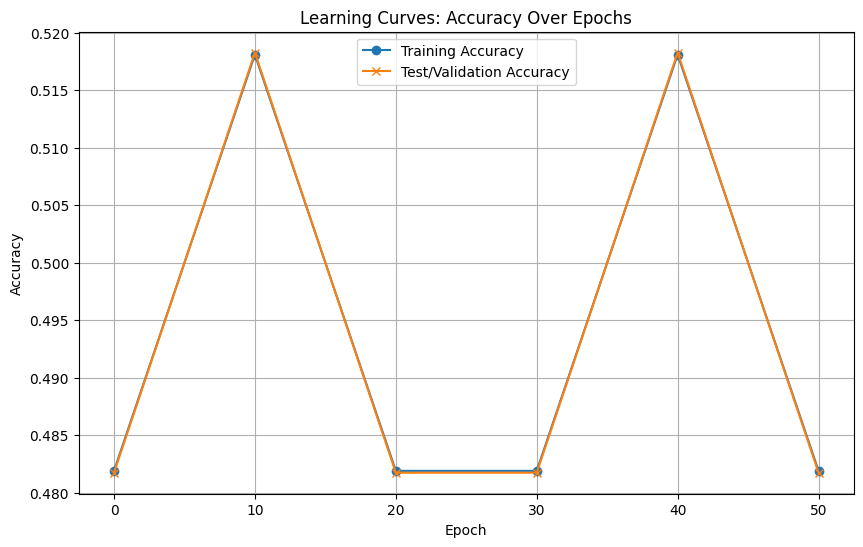


Training Complete. Final Train Acc: 0.4819, Final Test Acc: 0.4818


In [35]:
model = lenet5()
trainacc, valacc = train_CNN(model, train_loader, val_loader, lr=0.5, device=torch.device("cuda"))
accuracies["lenet5"] = (trainacc, valacc)

In [43]:
class alexnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=7, stride=2, padding=5),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(2)
            )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 10: Train Acc = 0.6777, Test Acc = 0.6659
Epoch 20: Train Acc = 0.8183, Test Acc = 0.7356
Epoch 30: Train Acc = 0.9273, Test Acc = 0.7242
Epoch 40: Train Acc = 0.9897, Test Acc = 0.7478
Epoch 50: Train Acc = 0.9908, Test Acc = 0.7364


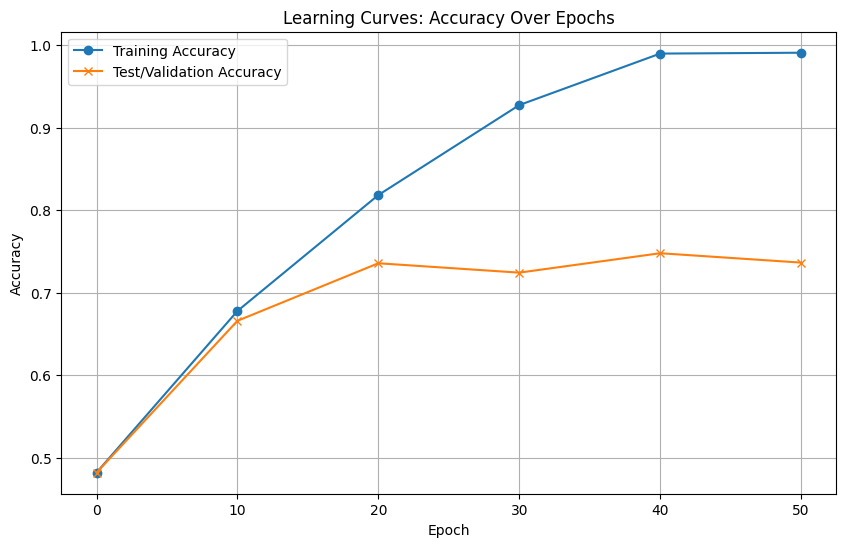


Training Complete. Final Train Acc: 0.9908, Final Test Acc: 0.7364


In [44]:
model = alexnet()
trainacc, valacc = train_CNN(model, train_loader, val_loader, device=torch.device("cuda"))
accuracies["alexnet"] = (trainacc, valacc)

In [45]:
class lenet5_relu_max_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(84),
            nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(2),
        )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

Epoch 0 (Initial): Train Acc = 0.5181, Test Acc = 0.5182
Epoch 10: Train Acc = 0.7576, Test Acc = 0.6561
Epoch 20: Train Acc = 0.9397, Test Acc = 0.6821
Epoch 30: Train Acc = 0.9896, Test Acc = 0.6675
Epoch 40: Train Acc = 0.9984, Test Acc = 0.6837
Epoch 50: Train Acc = 0.9993, Test Acc = 0.6740


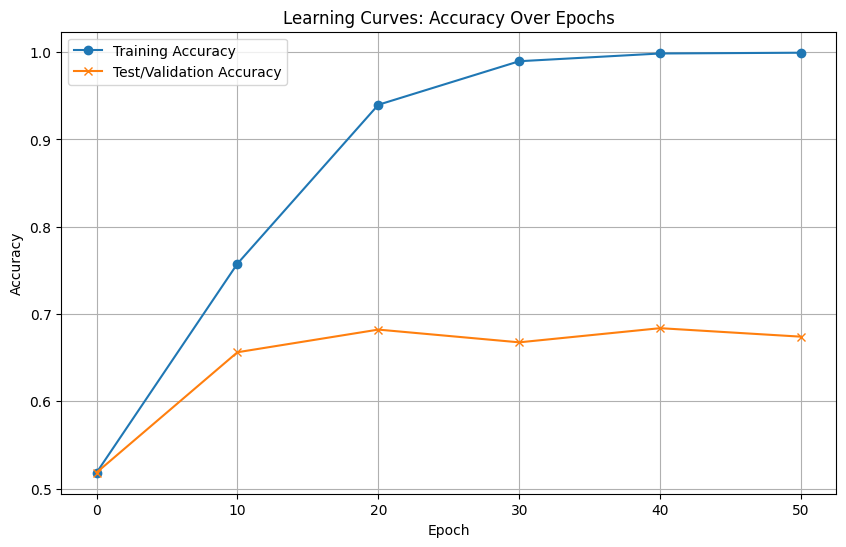


Training Complete. Final Train Acc: 0.9993, Final Test Acc: 0.6740


In [46]:
model = lenet5_relu_max_dropout()
trainacc, valacc = train_CNN(model, train_loader, val_loader)
accuracies["lenet5_relu_max_dropout"] = (trainacc, valacc)

In [47]:
class lenet5_relu(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.ReLU(),
            nn.LazyLinear(84),
            nn.ReLU(),
            nn.LazyLinear(2),
        )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 10: Train Acc = 0.8283, Test Acc = 0.6504
Epoch 20: Train Acc = 0.9743, Test Acc = 0.6659
Epoch 30: Train Acc = 0.9863, Test Acc = 0.6634
Epoch 40: Train Acc = 1.0000, Test Acc = 0.6780
Epoch 50: Train Acc = 1.0000, Test Acc = 0.6780


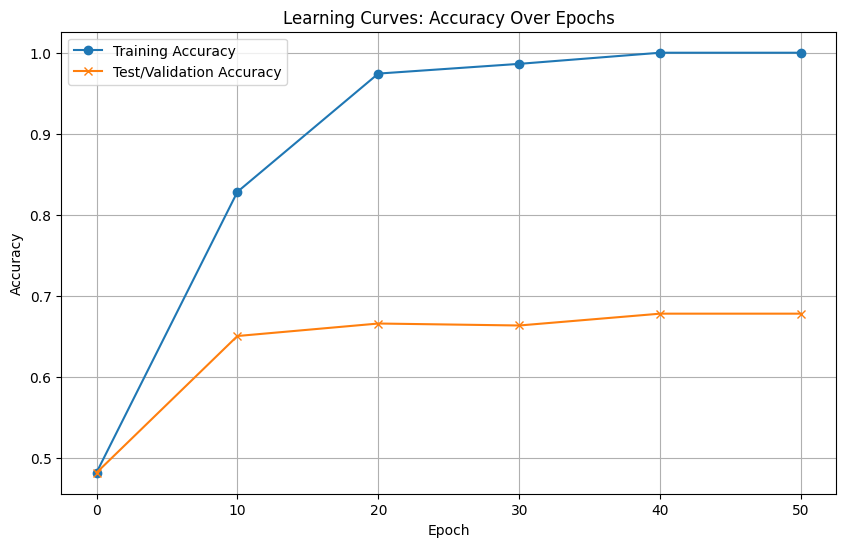


Training Complete. Final Train Acc: 1.0000, Final Test Acc: 0.6780


In [48]:
model = lenet5_relu()
trainacc, valacc = train_CNN(model, train_loader, val_loader, device=torch.device("cuda"))
accuracies["lenet5_relu"] = (trainacc, valacc)

In [49]:
class lenet5_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.Sigmoid(), nn.Dropout(p=0.5),
            nn.LazyLinear(84),
            nn.Sigmoid(), nn.Dropout(p=0.5),
            nn.LazyLinear(2),
        )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 10: Train Acc = 0.5181, Test Acc = 0.5182
Epoch 20: Train Acc = 0.5181, Test Acc = 0.5182
Epoch 30: Train Acc = 0.5181, Test Acc = 0.5182
Epoch 40: Train Acc = 0.5181, Test Acc = 0.5182
Epoch 50: Train Acc = 0.5181, Test Acc = 0.5182


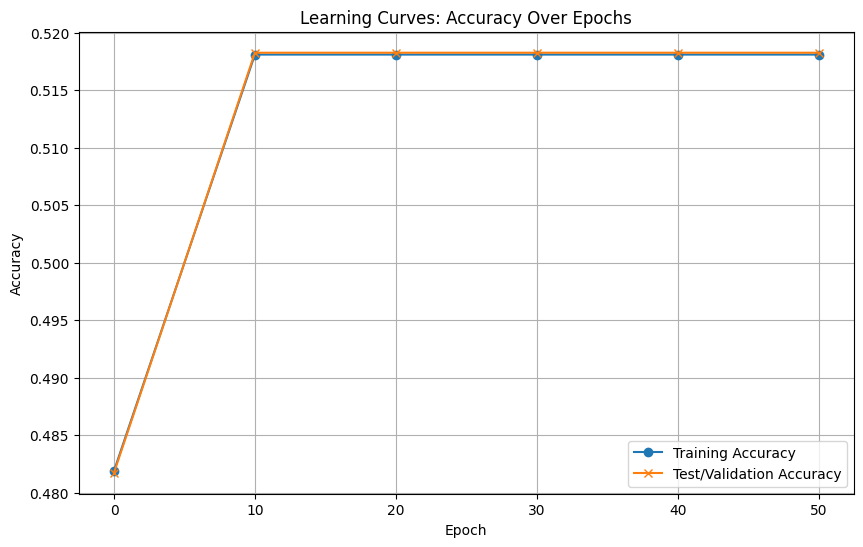


Training Complete. Final Train Acc: 0.5181, Final Test Acc: 0.5182


In [50]:
model = lenet5_dropout()
trainacc, valacc = train_CNN(model, train_loader, val_loader, device=torch.device("cuda"))
accuracies["lenet5_dropout"] = (trainacc, valacc)

In [51]:
class lenet5_max(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.Sigmoid(),
            nn.LazyLinear(84),
            nn.Sigmoid(),
            nn.LazyLinear(2),
        )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

Epoch 0 (Initial): Train Acc = 0.5181, Test Acc = 0.5182
Epoch 10: Train Acc = 0.5181, Test Acc = 0.5182
Epoch 20: Train Acc = 0.5174, Test Acc = 0.5174
Epoch 30: Train Acc = 0.6169, Test Acc = 0.6180
Epoch 40: Train Acc = 0.6115, Test Acc = 0.5977
Epoch 50: Train Acc = 0.6995, Test Acc = 0.6764


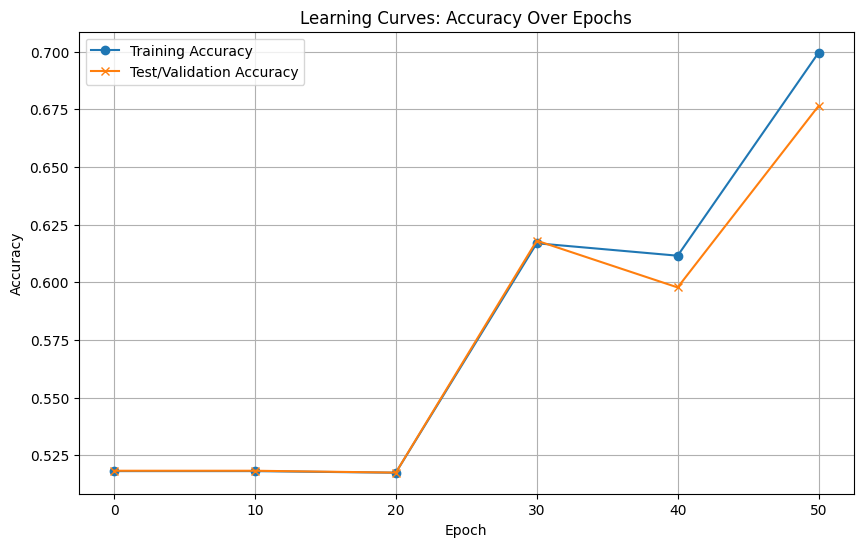


Training Complete. Final Train Acc: 0.6995, Final Test Acc: 0.6764


In [52]:
model = lenet5_max()
trainacc, valacc = train_CNN(model, train_loader, val_loader, device=torch.device("cuda"))
accuracies["lenet5_max"] = (trainacc, valacc)

In [56]:
class lenet5_relu_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(84),
            nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(2),
        )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0 (Initial): Train Acc = 0.5181, Test Acc = 0.5182
Epoch 10: Train Acc = 0.7282, Test Acc = 0.6780
Epoch 20: Train Acc = 0.8565, Test Acc = 0.7048
Epoch 30: Train Acc = 0.9370, Test Acc = 0.6845
Epoch 40: Train Acc = 0.9803, Test Acc = 0.6675
Epoch 50: Train Acc = 0.9903, Test Acc = 0.6667


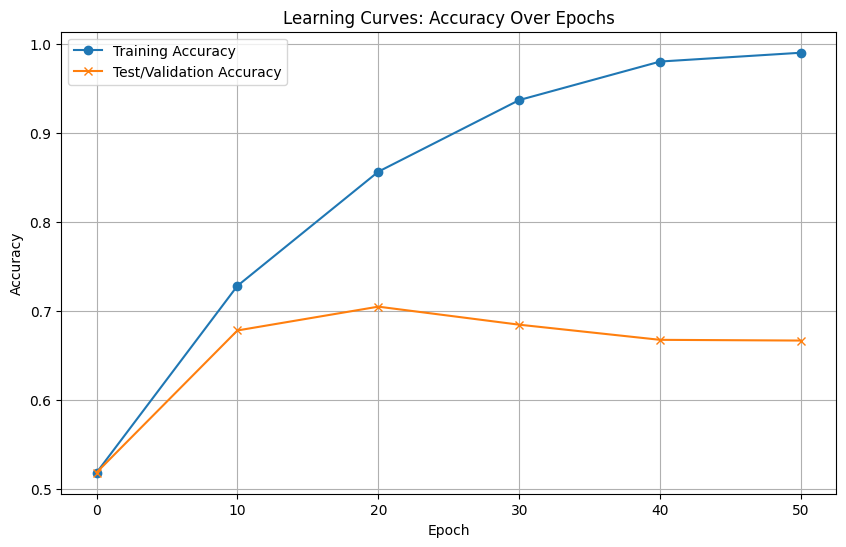


Training Complete. Final Train Acc: 0.9903, Final Test Acc: 0.6667


In [57]:
model = lenet5_relu_dropout()
trainacc, valacc = train_CNN(model, train_loader, val_loader, device=torch.device("cuda"))
accuracies["lenet5_relu_dropout"] = (trainacc, valacc)

In [58]:
class lenet5_relu_max(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.ReLU(),
            nn.LazyLinear(84),
            nn.ReLU(),
            nn.LazyLinear(2),
        )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

Epoch 0 (Initial): Train Acc = 0.5181, Test Acc = 0.5182
Epoch 10: Train Acc = 0.8991, Test Acc = 0.6659
Epoch 20: Train Acc = 0.9863, Test Acc = 0.6618
Epoch 30: Train Acc = 0.9970, Test Acc = 0.6821
Epoch 40: Train Acc = 1.0000, Test Acc = 0.6634
Epoch 50: Train Acc = 1.0000, Test Acc = 0.6675


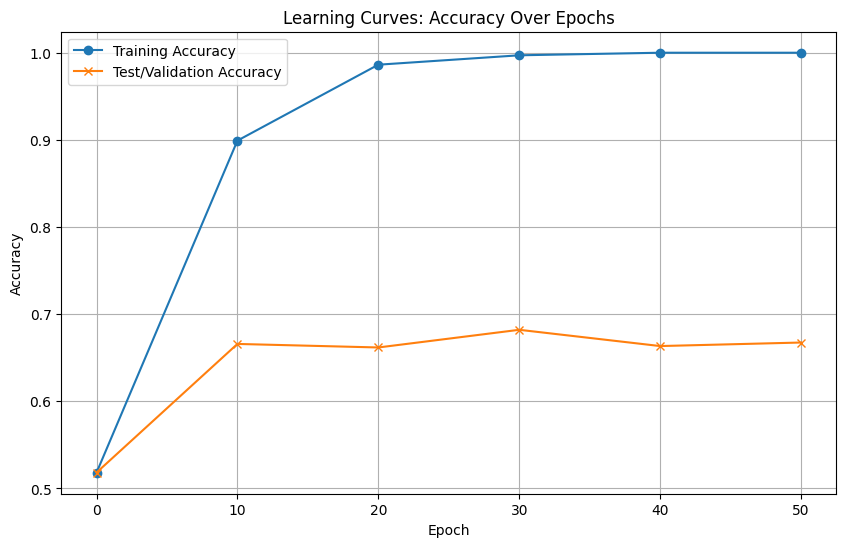


Training Complete. Final Train Acc: 1.0000, Final Test Acc: 0.6675


In [60]:
model = lenet5_relu_max()
trainacc, valacc = train_CNN(model, train_loader, val_loader, device=torch.device("cuda"))
accuracies["lenet5_relu_max"] = (trainacc, valacc)

In [53]:
class lenet5_deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=7, stride=2, padding=5),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.AvgPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.AvgPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.Sigmoid(),
            nn.LazyLinear(4096), nn.Sigmoid(),
            nn.LazyLinear(2)
            )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 10: Train Acc = 0.5181, Test Acc = 0.5182
Epoch 20: Train Acc = 0.4819, Test Acc = 0.4818
Epoch 30: Train Acc = 0.5181, Test Acc = 0.5182
Epoch 40: Train Acc = 0.5181, Test Acc = 0.5182
Epoch 50: Train Acc = 0.5181, Test Acc = 0.5182


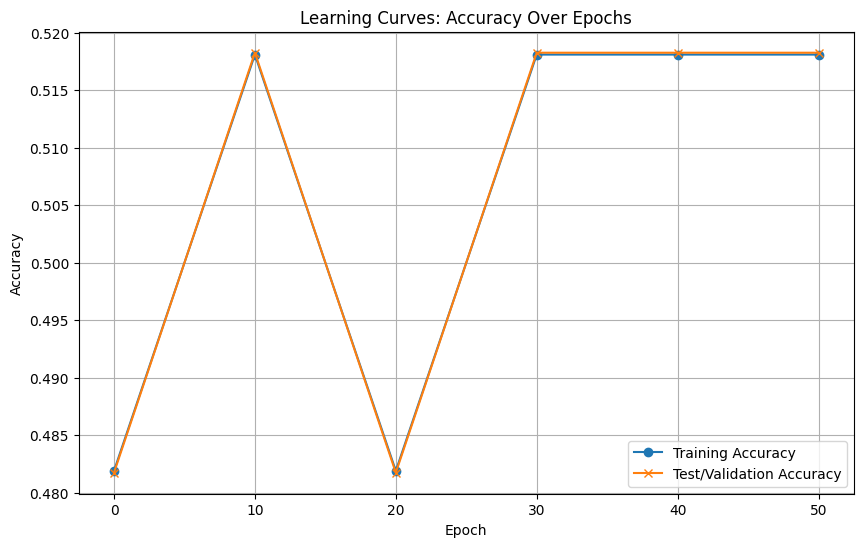


Training Complete. Final Train Acc: 0.5181, Final Test Acc: 0.5182


In [54]:
model = lenet5_deep()
trainacc, valacc = train_CNN(model, train_loader, val_loader, device=torch.device("cuda"))
accuracies["lenet5_deep"] = (trainacc, valacc)

In [65]:
accuracies

{'lenet5': (0.48191304347826086, 0.48175182481751827),
 'alexnet': (0.9907826086956522, 0.7364152473641524),
 'lenet5_relu_max_dropout': (0.9993043478260869, 0.6739659367396593),
 'lenet5_relu': (1.0, 0.6780210867802109),
 'lenet5_dropout': (0.5180869565217391, 0.5182481751824818),
 'lenet5_max': (0.6994782608695652, 0.6763990267639902),
 'lenet5_relu_dropout': (0.9902608695652174, 0.6666666666666666),
 'lenet5_relu_max': (1.0, 0.667477696674777),
 'lenet5_deep': (0.5180869565217391, 0.5182481751824818)}

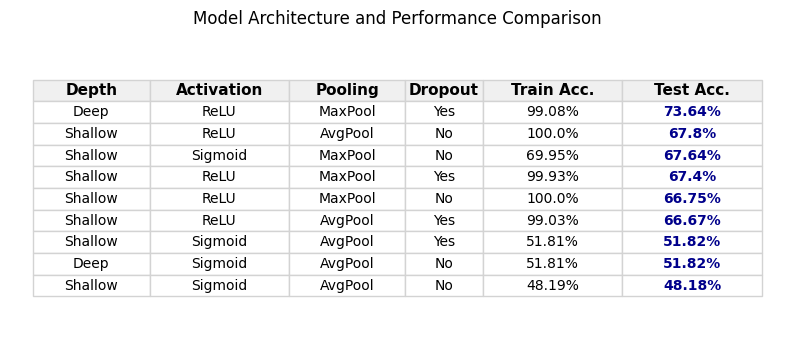

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- DATA ASSUMPTION ---
# Assuming 'accuracies' dictionary is available in your environment.
data = accuracies

# 1. Convert to DataFrame and Extract Model ID
df = pd.DataFrame(data).T.reset_index()
df.columns = ['Model ID', 'Train Accuracy', 'Test Accuracy']

# 2. Feature Engineering and Architectural Overrides
def parse_model_features(model_name):
    features = {'Activation Function': 'Sigmoid', 'Pooling Type': 'AvgPool', 'Has Dropout': 'No', 'Architecture Depth': 'Shallow'}

    # Specific Overrides
    if model_name == 'alexnet':
        features.update({'Architecture Depth': 'Deep', 'Activation Function': 'ReLU', 'Pooling Type': 'MaxPool', 'Has Dropout': 'Yes'})
        return pd.Series(features)
    if model_name == 'lenet5_deep':
        features.update({'Architecture Depth': 'Deep', 'Activation Function': 'Sigmoid', 'Pooling Type': 'AvgPool'})
        return pd.Series(features)

    # Generic Features
    if 'relu' in model_name: features['Activation Function'] = 'ReLU'
    if 'max' in model_name: features['Pooling Type'] = 'MaxPool'
    if 'dropout' in model_name: features['Has Dropout'] = 'Yes'
    return pd.Series(features)

df[['Activation Function', 'Pooling Type', 'Has Dropout', 'Architecture Depth']] = df['Model ID'].apply(parse_model_features)

# 3. Sort by Test Accuracy (using float values before formatting)
df = df.sort_values('Test Accuracy', ascending=False)

# 4. Format Accuracy Columns for display
df['Train Accuracy'] = (df['Train Accuracy'] * 100).round(2).astype(str) + '%'
df['Test Accuracy'] = (df['Test Accuracy'] * 100).round(2).astype(str) + '%'

# 5. Select, order, and rename the final columns
final_df = df[[
    'Architecture Depth',
    'Activation Function',
    'Pooling Type',
    'Has Dropout',
    'Train Accuracy',
    'Test Accuracy'
]].reset_index(drop=True)

# Rename the columns for the final display
final_df.columns = [
    'Depth',  # Shortened
    'Activation', # Shortened
    'Pooling',    # Shortened
    'Dropout', # Shortened 'Has Dropout' to 'Dropout'
    'Train Acc.',
    'Test Acc.'
]

# --- MATPLOTLIB VISUALIZATION ---
# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, final_df.shape[0] * 0.45))
ax.set_title("Model Architecture and Performance Comparison")
ax.axis('off') # Hide the axes

# Define table properties
table_data = final_df.values
column_labels = final_df.columns

# Set column widths (Adjusted for the new, shorter names)
# Total width must sum to 1.0 (approximately)
colWidths = [0.15, 0.18, 0.15, 0.10, 0.18, 0.18]

# Create the table
table = ax.table(
    cellText=table_data,
    colLabels=column_labels,
    colWidths=colWidths,
    loc='center',
    cellLoc='center'
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.0, 1.3)

# Apply grid lines and formatting
for (i, j), cell in table.get_celld().items():
    cell.set_edgecolor('lightgray')

    # Style the header
    if i == 0:
        cell.set_fontsize(11)
        cell.set_facecolor('#f0f0f0')
        cell.set_text_props(weight='bold')

    # Highlight the Test Accuracy column (column index 5)
    if j == 5 and i > 0:
        cell.set_text_props(color='darkblue', weight='bold')

# Display the plot
plt.show()

In [112]:
import torchvision.transforms as transforms
import os

# --- Configuration (Ensure these match your global settings) ---
TARGET_SIZE = 50
PROJECT_DIR = '/content/fast_data/' # Assuming this is your project root
IMAGE_PATCH_DIR = os.path.join(PROJECT_DIR, 'cropped_images')
# ----------------------------------------------------------------

# --- DEFINE ISOLATED COLOR JITTER OBJECTS ---

# Jitter 1: Brightness Only (Range 0.5)
brightness_aug = transforms.ColorJitter(
    brightness=0.5,
    contrast=0.0,
    saturation=0.0,
    hue=0.0
)
# Jitter 2: Contrast Only (Range 0.5)
contrast_aug = transforms.ColorJitter(
    brightness=0.0,
    contrast=0.5,
    saturation=0.0,
    hue=0.0
)
# Jitter 3: Saturation Only (Range 0.5)
saturation_aug = transforms.ColorJitter(
    brightness=0.0,
    contrast=0.0,
    saturation=0.5,
    hue=0.0
)
# Jitter 4: Hue Only (Range 0.5) <--- NEW OBJECT
hue_aug = transforms.ColorJitter(
    brightness=0.0,
    contrast=0.0,
    saturation=0.0,
    hue=0.5
)


## --- 1. Pipeline for X-Reflections (Horizontal Flip Only) ---
train_transforms_hflip = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    transforms.RandomHorizontalFlip(p=0.50),
    transforms.ToTensor(),
])

## --- 2. Pipeline for Y-Reflections (Vertical Flip Only) ---
train_transforms_vflip = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
])

# --- 3. Pipeline for BRIGHTNESS Jitter Only ---
train_transforms_brightness = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    brightness_aug,              # Applies Brightness shift only
    transforms.ToTensor(),
])

# --- 4. Pipeline for CONTRAST Jitter Only ---
train_transforms_contrast = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    contrast_aug,                # Applies Contrast shift only
    transforms.ToTensor(),
])

# --- 5. Pipeline for SATURATION Jitter Only ---
train_transforms_saturation = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    saturation_aug,              # Applies Saturation shift only
    transforms.ToTensor(),
])

# --- 6. Pipeline for HUE Jitter Only --- <--- NEW PIPELINE
train_transforms_hue = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    hue_aug,                     # Applies Hue shift only
    transforms.ToTensor(),
])


print("✅ Six distinct augmentation pipelines defined: H-Flip, V-Flip, Brightness Only, Contrast Only, Saturation Only, and Hue Only.")

✅ Six distinct augmentation pipelines defined: H-Flip, V-Flip, Brightness Only, Contrast Only, Saturation Only, and Hue Only.


In [113]:
# Assuming df_master and custom_filter are defined in your environment
# And that the function 'create_loaders' is accessible
# Also assuming the six new transform pipelines (train_transforms_hflip,
# train_transforms_vflip, train_transforms_brightness, train_transforms_contrast,
# train_transforms_saturation, train_transforms_hue) are defined.

# --- DataLoader 1: Horizontal Flip Test ---
hflip_train_loader, _, _ = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=custom_filter,
    transform=train_transforms_hflip
)
print("✅ DataLoader Set 1 (Horizontal Flip) created.")


# --- DataLoader 2: Vertical Flip Test ---
vflip_train_loader, _, _ = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=custom_filter,
    transform=train_transforms_vflip
)
print("✅ DataLoader Set 2 (Vertical Flip) created.")


# --- DataLoader 3: Brightness Jitter Only Test ---
brightness_train_loader, _, _ = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=custom_filter,
    transform=train_transforms_brightness
)
print("✅ DataLoader Set 3 (Brightness Jitter Only) created.")


# --- DataLoader 4: Contrast Jitter Only Test ---
contrast_train_loader, _, _ = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=custom_filter,
    transform=train_transforms_contrast
)
print("✅ DataLoader Set 4 (Contrast Jitter Only) created.")


# --- DataLoader 5: Saturation Jitter Only Test ---
saturation_train_loader, _, _ = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=custom_filter,
    transform=train_transforms_saturation
)
print("✅ DataLoader Set 5 (Saturation Jitter Only) created.")


# --- DataLoader 6: Hue Jitter Only Test ---
hue_train_loader, _, _ = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=custom_filter,
    transform=train_transforms_hue
)
print("✅ DataLoader Set 6 (Hue Jitter Only) created.")

Applying filters: {'Tumor': 'canine lymphoma', 'Scanner': '3D Histech', 'Origin': 'VMU Vienna'}
Original size: 26286. Filtered size: 8216.

--- Data Split Summary ---
Original Total Annotations: 8216
Train Annotations: 5750 (70.0%)
Validation Annotations: 1233 (15.0%)
Test Annotations: 1233 (15.0%)

Train/Validation/Test DataLoaders created successfully.
Train Loader batch size: 32


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Verification Batch 1:
  Image Batch Shape: torch.Size([32, 3, 50, 50])
  Expected Image Size (H, W): 50x50
  Labels in Batch (first 5): tensor([1, 1, 1, 1, 0])
✅ DataLoader Set 1 (Horizontal Flip) created.
Applying filters: {'Tumor': 'canine lymphoma', 'Scanner': '3D Histech', 'Origin': 'VMU Vienna'}
Original size: 26286. Filtered size: 8216.

--- Data Split Summary ---
Original Total Annotations: 8216
Train Annotations: 5750 (70.0%)
Validation Annotations: 1233 (15.0%)
Test Annotations: 1233 (15.0%)

Train/Validation/Test DataLoaders created successfully.
Train Loader batch size: 32


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Verification Batch 1:
  Image Batch Shape: torch.Size([32, 3, 50, 50])
  Expected Image Size (H, W): 50x50
  Labels in Batch (first 5): tensor([1, 1, 0, 1, 0])
✅ DataLoader Set 2 (Vertical Flip) created.
Applying filters: {'Tumor': 'canine lymphoma', 'Scanner': '3D Histech', 'Origin': 'VMU Vienna'}
Original size: 26286. Filtered size: 8216.

--- Data Split Summary ---
Original Total Annotations: 8216
Train Annotations: 5750 (70.0%)
Validation Annotations: 1233 (15.0%)
Test Annotations: 1233 (15.0%)

Train/Validation/Test DataLoaders created successfully.
Train Loader batch size: 32


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Verification Batch 1:
  Image Batch Shape: torch.Size([32, 3, 50, 50])
  Expected Image Size (H, W): 50x50
  Labels in Batch (first 5): tensor([1, 0, 0, 0, 0])
✅ DataLoader Set 3 (Brightness Jitter Only) created.
Applying filters: {'Tumor': 'canine lymphoma', 'Scanner': '3D Histech', 'Origin': 'VMU Vienna'}
Original size: 26286. Filtered size: 8216.

--- Data Split Summary ---
Original Total Annotations: 8216
Train Annotations: 5750 (70.0%)
Validation Annotations: 1233 (15.0%)
Test Annotations: 1233 (15.0%)

Train/Validation/Test DataLoaders created successfully.
Train Loader batch size: 32


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Verification Batch 1:
  Image Batch Shape: torch.Size([32, 3, 50, 50])
  Expected Image Size (H, W): 50x50
  Labels in Batch (first 5): tensor([0, 1, 1, 1, 1])
✅ DataLoader Set 4 (Contrast Jitter Only) created.
Applying filters: {'Tumor': 'canine lymphoma', 'Scanner': '3D Histech', 'Origin': 'VMU Vienna'}
Original size: 26286. Filtered size: 8216.

--- Data Split Summary ---
Original Total Annotations: 8216
Train Annotations: 5750 (70.0%)
Validation Annotations: 1233 (15.0%)
Test Annotations: 1233 (15.0%)

Train/Validation/Test DataLoaders created successfully.
Train Loader batch size: 32


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Verification Batch 1:
  Image Batch Shape: torch.Size([32, 3, 50, 50])
  Expected Image Size (H, W): 50x50
  Labels in Batch (first 5): tensor([1, 0, 1, 0, 1])
✅ DataLoader Set 5 (Saturation Jitter Only) created.
Applying filters: {'Tumor': 'canine lymphoma', 'Scanner': '3D Histech', 'Origin': 'VMU Vienna'}
Original size: 26286. Filtered size: 8216.

--- Data Split Summary ---
Original Total Annotations: 8216
Train Annotations: 5750 (70.0%)
Validation Annotations: 1233 (15.0%)
Test Annotations: 1233 (15.0%)

Train/Validation/Test DataLoaders created successfully.
Train Loader batch size: 32


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Verification Batch 1:
  Image Batch Shape: torch.Size([32, 3, 50, 50])
  Expected Image Size (H, W): 50x50
  Labels in Batch (first 5): tensor([1, 0, 0, 0, 0])
✅ DataLoader Set 6 (Hue Jitter Only) created.


In [114]:
class lenet5_relu_max_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(84),
            nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(2),
        )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

In [115]:
aug_accuracies={}

Epoch 0 (Initial): Train Acc = 0.5158, Test Acc = 0.4964
Epoch 10: Train Acc = 0.7292, Test Acc = 0.6545


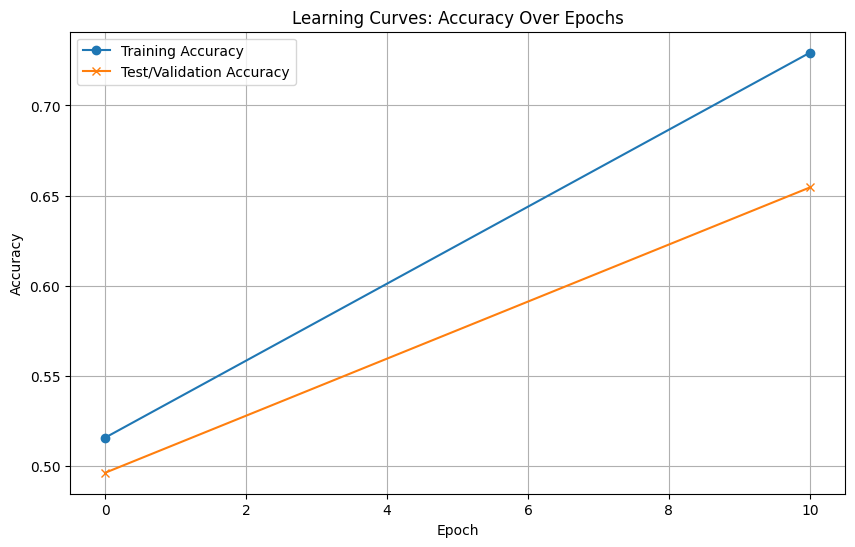


Training Complete. Final Train Acc: 0.7292, Final Test Acc: 0.6545


In [116]:
model = lenet5_relu_max_dropout()
trainacc, valacc = train_CNN(model, train_loader, val_loader, device=torch.device("cuda"), num_epochs=10)
aug_accuracies["no_augmentation"] = (trainacc, valacc)

Epoch 0 (Initial): Train Acc = 0.5546, Test Acc = 0.5515
Epoch 10: Train Acc = 0.6892, Test Acc = 0.6561


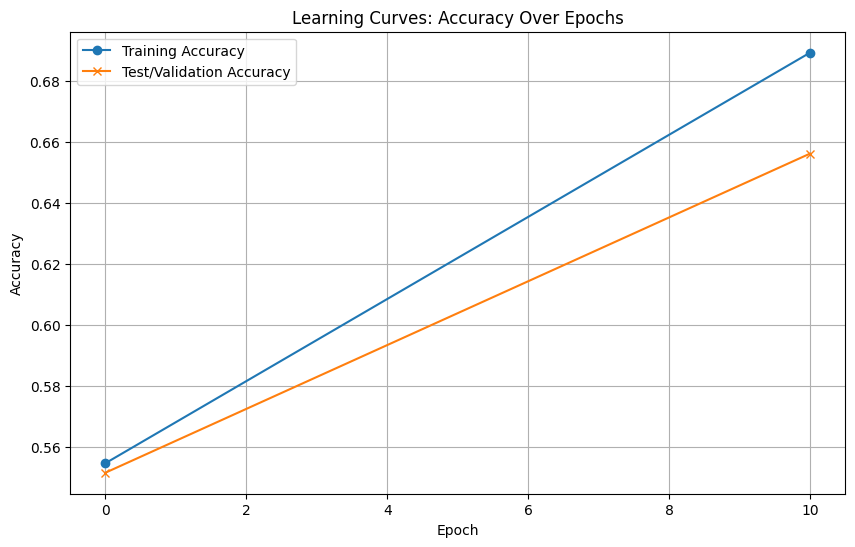


Training Complete. Final Train Acc: 0.6892, Final Test Acc: 0.6561


In [117]:
model = lenet5_relu_max_dropout()
trainacc, valacc = train_CNN(model, hflip_train_loader, val_loader, device=torch.device("cuda"), num_epochs=10)
aug_accuracies["horizonal_flip"] = (trainacc, valacc)

Epoch 0 (Initial): Train Acc = 0.5181, Test Acc = 0.5182
Epoch 10: Train Acc = 0.6850, Test Acc = 0.6561


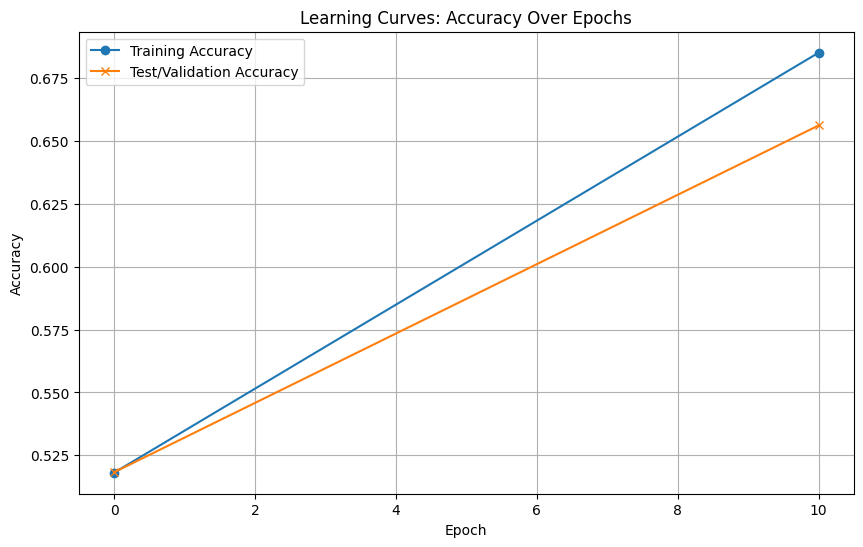


Training Complete. Final Train Acc: 0.6850, Final Test Acc: 0.6561


In [118]:
model = lenet5_relu_max_dropout()
trainacc, valacc = train_CNN(model, vflip_train_loader, val_loader, device=torch.device("cuda"), num_epochs=10)
aug_accuracies["vertical_flip"] = (trainacc, valacc)

Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 10: Train Acc = 0.6710, Test Acc = 0.6577


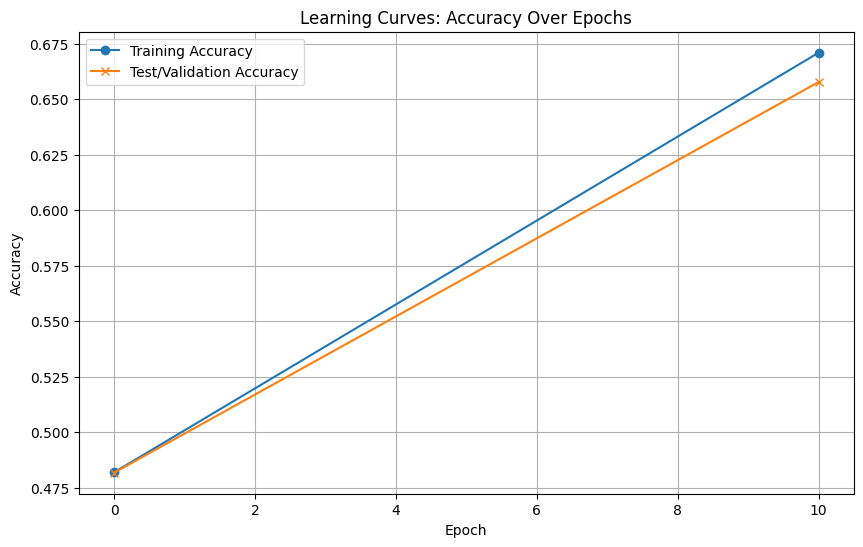


Training Complete. Final Train Acc: 0.6710, Final Test Acc: 0.6577


In [119]:
model = lenet5_relu_max_dropout()
trainacc, valacc = train_CNN(model, brightness_train_loader, val_loader, device=torch.device("cuda"), num_epochs=10)
aug_accuracies["brightness"] = (trainacc, valacc)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0 (Initial): Train Acc = 0.4793, Test Acc = 0.4931
Epoch 10: Train Acc = 0.6998, Test Acc = 0.6204


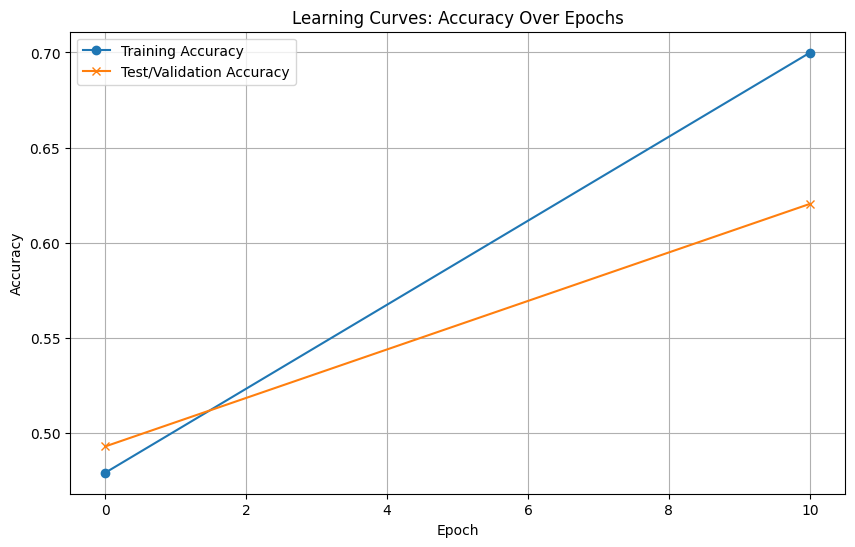


Training Complete. Final Train Acc: 0.6998, Final Test Acc: 0.6204


In [120]:
model = lenet5_relu_max_dropout()
trainacc, valacc = train_CNN(model, contrast_train_loader, val_loader, device=torch.device("cuda"), num_epochs=10)
aug_accuracies["constrast"] = (trainacc, valacc)

Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 10: Train Acc = 0.7746, Test Acc = 0.6431


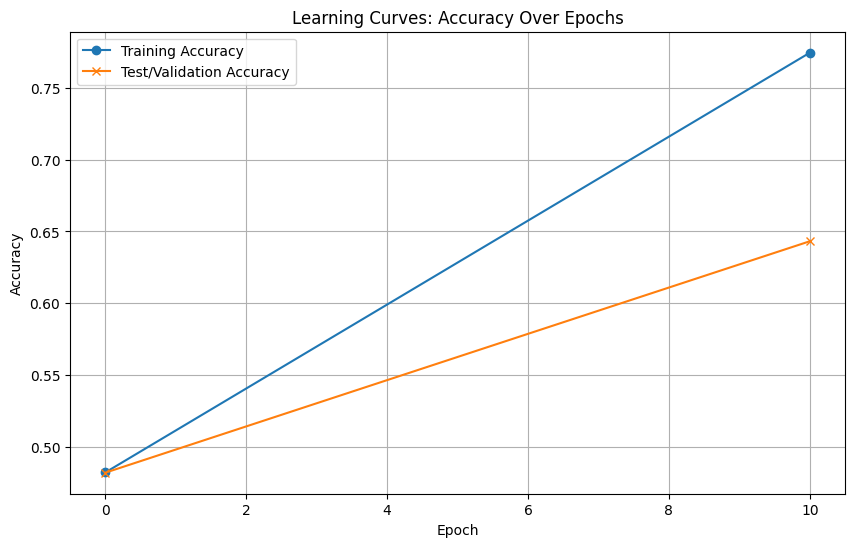


Training Complete. Final Train Acc: 0.7746, Final Test Acc: 0.6431


In [121]:
model = lenet5_relu_max_dropout()
trainacc, valacc = train_CNN(model, saturation_train_loader, val_loader, device=torch.device("cuda"), num_epochs=10)
aug_accuracies["saturation"] = (trainacc, valacc)

Epoch 0 (Initial): Train Acc = 0.5132, Test Acc = 0.5158
Epoch 10: Train Acc = 0.7480, Test Acc = 0.6431


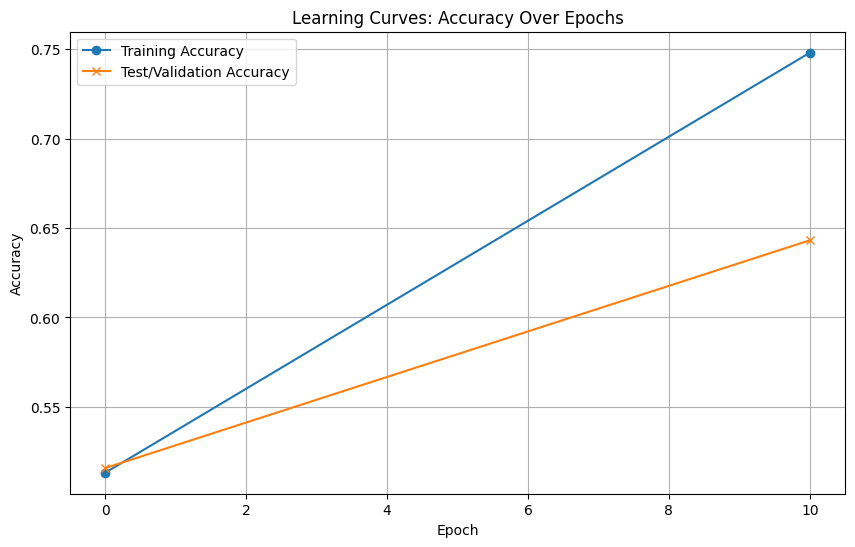


Training Complete. Final Train Acc: 0.7480, Final Test Acc: 0.6431


In [122]:
model = lenet5_relu_max_dropout()
trainacc, valacc = train_CNN(model, hue_train_loader, val_loader, device=torch.device("cuda"), num_epochs=10)
aug_accuracies["hue"] = (trainacc, valacc)

In [123]:
aug_accuracies

{'no_augmentation': (0.7292173913043478, 0.6545012165450121),
 'horizonal_flip': (0.6892173913043478, 0.6561232765612328),
 'vertical_flip': (0.6850434782608695, 0.6561232765612328),
 'brightness': (0.6709565217391305, 0.6577453365774534),
 'constrast': (0.6998260869565217, 0.6204379562043796),
 'saturation': (0.7746086956521739, 0.643146796431468),
 'hue': (0.748, 0.643146796431468)}

augmentation_performance_bar_chart.png


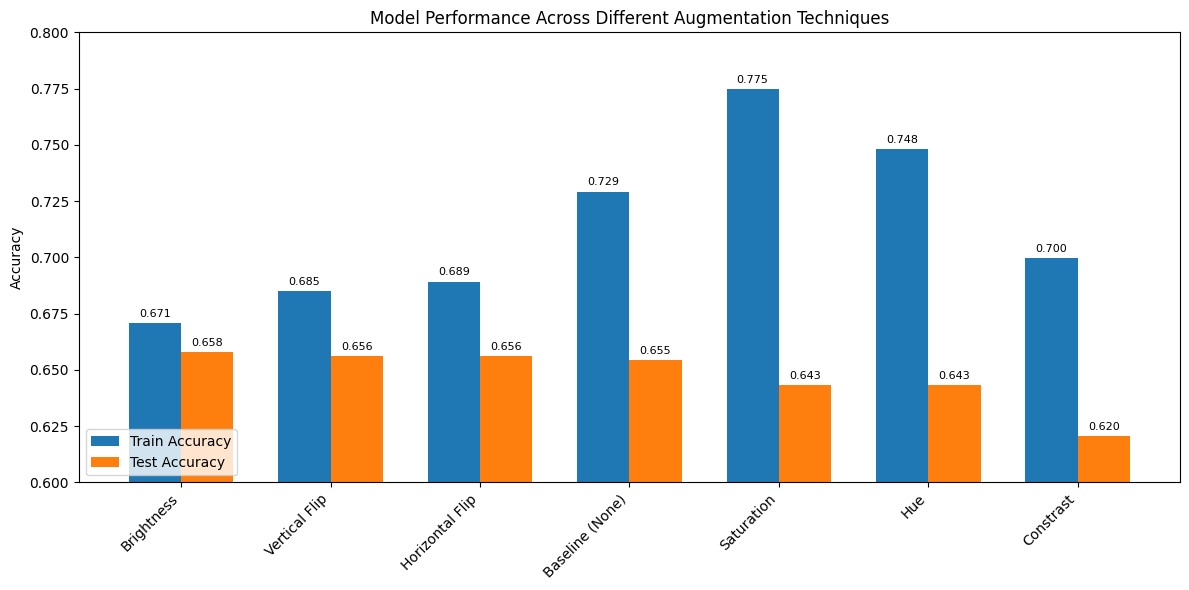

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data provided by the user
results = aug_accuracies

# 1. Load data into DataFrame
df = pd.DataFrame(results).T.reset_index()
df.columns = ['Augmentation', 'Train Accuracy', 'Test Accuracy']

# Standardize Augmentation Names for Plotting
df['Augmentation'] = df['Augmentation'].str.replace('_', ' ').str.title().str.replace('Horizonal', 'Horizontal')
df.loc[df['Augmentation'] == 'No Augmentation', 'Augmentation'] = 'Baseline (None)'

# 2. Sort the DataFrame by Test Accuracy
df = df.sort_values(by='Test Accuracy', ascending=False)

# 3. Setup for Grouped Bar Chart
labels = df['Augmentation']
train_acc = df['Train Accuracy']
test_acc = df['Test Accuracy']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# 4. Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - width/2, train_acc, width, label='Train Accuracy', color='#1f77b4')
rects2 = ax.bar(x + width/2, test_acc, width, label='Test Accuracy', color='#ff7f0e')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance Across Different Augmentation Techniques')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend(loc='lower left')
ax.set_ylim(0.6, 0.8) # Set a reasonable y-limit for better visual comparison

# Function to add labels on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8)

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig('augmentation_performance_bar_chart.png')
print("augmentation_performance_bar_chart.png")

In [128]:
import torchvision.transforms as transforms
import os

# --- Configuration (Assumed to be defined) ---
# TARGET_SIZE = 50
# PROJECT_DIR = '/content/fast_data/'
# df_master = ...
# custom_filter = ...
# create_loaders = ...
# ---------------------------------------------

# --- 1. Define ISOLATED Brightness Jitter Object ---
# Use the same parameters as the single brightness test (other jitters set to 0.0)
brightness_aug_combined = transforms.ColorJitter(
    brightness=0.5,
    contrast=0.0,
    saturation=0.0,
    hue=0.0
)

## --- 2. Pipeline for Combined Augmentations ---
# Includes CenterCrop, Horizontal Flip, Vertical Flip, Brightness Jitter, and ToTensor
train_transforms_combined = transforms.Compose([
    # Assumed to be defined: transforms.CenterCrop(TARGET_SIZE),
    transforms.CenterCrop(TARGET_SIZE),

    # 1. Geometric Augmentations (Horizontal and Vertical Flip)
    transforms.RandomHorizontalFlip(p=0.50),
    transforms.RandomVerticalFlip(p=0.5),

    # 2. Color Augmentation (Brightness Only)
    brightness_aug_combined,

    # 3. Conversion
    transforms.ToTensor(),
])

print("✅ Combined augmentation pipeline (H-Flip + V-Flip + Brightness) defined.")


# --- 3. Create the Combined DataLoader ---
# Assuming df_master and custom_filter are defined in your environment
# And that the function 'create_loaders' is accessible

combined_train_loader, _, _ = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=custom_filter,
    transform=train_transforms_combined
)
print("✅ DataLoader Set 7 (Combined Optimized Augmentation) created.")

✅ Combined augmentation pipeline (H-Flip + V-Flip + Brightness) defined.
Applying filters: {'Tumor': 'canine lymphoma', 'Scanner': '3D Histech', 'Origin': 'VMU Vienna'}
Original size: 26286. Filtered size: 8216.

--- Data Split Summary ---
Original Total Annotations: 8216
Train Annotations: 5750 (70.0%)
Validation Annotations: 1233 (15.0%)
Test Annotations: 1233 (15.0%)

Train/Validation/Test DataLoaders created successfully.
Train Loader batch size: 32


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Verification Batch 1:
  Image Batch Shape: torch.Size([32, 3, 50, 50])
  Expected Image Size (H, W): 50x50
  Labels in Batch (first 5): tensor([1, 1, 1, 0, 0])
✅ DataLoader Set 7 (Combined Optimized Augmentation) created.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 10: Train Acc = 0.5873, Test Acc = 0.5831
Epoch 20: Train Acc = 0.7330, Test Acc = 0.7105
Epoch 30: Train Acc = 0.7995, Test Acc = 0.7624
Epoch 40: Train Acc = 0.8235, Test Acc = 0.7762
Epoch 50: Train Acc = 0.8492, Test Acc = 0.7705


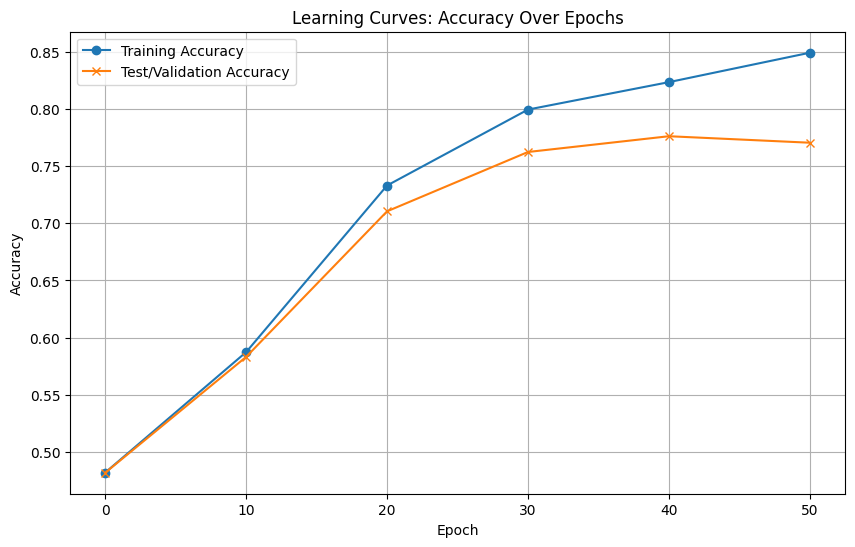


Training Complete. Final Train Acc: 0.8492, Final Test Acc: 0.7705
0.8492173913043478 0.7704785077047851


In [130]:
model = alexnet()
trainacc, valacc = train_CNN(model, combined_train_loader, val_loader, device=torch.device("cuda"), num_epochs=50)

In [161]:
import torchvision.transforms as transforms
import os

# --- Configuration (Assumed to be defined) ---
TARGET_SIZE = 60
# PROJECT_DIR = '/content/fast_data/'
# df_master = ...
# custom_filter = ...
# create_loaders = ...
# ---------------------------------------------

# --- 1. Define Augmentation Objects ---
brightness_aug_combined = transforms.ColorJitter(
    brightness=0.5,
    contrast=0.0,
    saturation=0.0,
    hue=0.0
)

## --- 2. Pipeline for Training (Augmented) ---
train_transforms_combined = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    transforms.RandomHorizontalFlip(p=0.50),
    transforms.RandomVerticalFlip(p=0.5),
    brightness_aug_combined,
    transforms.ToTensor(),
])
print("✅ Training (Augmented) pipeline defined.")


## --- 3. Pipeline for Evaluation (Standard) ---
# Only standardization: CenterCrop to fix size and ToTensor
eval_transforms_standard = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    transforms.ToTensor(),
])
print("✅ Evaluation (Standard) pipeline defined.")


# --- 4. FIRST CALL: Get the Training Loader (with Augmentation) ---
# We only care about the first return value (train_loader) here.
combined_train_loader_60x60, _, _ = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=custom_filter,
    transform=train_transforms_combined # <-- Uses AUGMENTED transform
)
print("✅ DataLoader Set 8.1 (Training Loader) created.")


# --- 5. SECOND CALL: Get the Val/Test Loaders (with Standard Transform) ---
# We ignore the first return value (a non-augmented train_loader)
_, val_loader_60x60, test_loader_60x60 = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=custom_filter,
    transform=eval_transforms_standard # <-- Uses STANDARD transform
)
print("✅ DataLoader Set 8.2 (Validation/Test Loaders) created.")

print("\nSuccessfully separated transforms: Augmentation for training, Standardization for evaluation.")

✅ Training (Augmented) pipeline defined.
✅ Evaluation (Standard) pipeline defined.
Applying filters: {'Tumor': 'canine lymphoma', 'Scanner': '3D Histech', 'Origin': 'VMU Vienna'}
Original size: 26286. Filtered size: 8216.

--- Data Split Summary ---
Original Total Annotations: 8216
Train Annotations: 5750 (70.0%)
Validation Annotations: 1233 (15.0%)
Test Annotations: 1233 (15.0%)

Train/Validation/Test DataLoaders created successfully.
Train Loader batch size: 32


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Verification Batch 1:
  Image Batch Shape: torch.Size([32, 3, 60, 60])
  Expected Image Size (H, W): 60x60
  Labels in Batch (first 5): tensor([0, 0, 0, 1, 1])
✅ DataLoader Set 8.1 (Training Loader) created.
Applying filters: {'Tumor': 'canine lymphoma', 'Scanner': '3D Histech', 'Origin': 'VMU Vienna'}
Original size: 26286. Filtered size: 8216.

--- Data Split Summary ---
Original Total Annotations: 8216
Train Annotations: 5750 (70.0%)
Validation Annotations: 1233 (15.0%)
Test Annotations: 1233 (15.0%)

Train/Validation/Test DataLoaders created successfully.
Train Loader batch size: 32


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Verification Batch 1:
  Image Batch Shape: torch.Size([32, 3, 60, 60])
  Expected Image Size (H, W): 60x60
  Labels in Batch (first 5): tensor([0, 0, 0, 0, 0])
✅ DataLoader Set 8.2 (Validation/Test Loaders) created.

Successfully separated transforms: Augmentation for training, Standardization for evaluation.


In [140]:
class alexnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=7, stride=2, padding=5),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(2)
            )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

In [141]:
padding_accuracies = {}

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 10: Train Acc = 0.5536, Test Acc = 0.5434
Epoch 20: Train Acc = 0.7339, Test Acc = 0.6983
Epoch 30: Train Acc = 0.7793, Test Acc = 0.7324
Epoch 40: Train Acc = 0.8117, Test Acc = 0.7543
Epoch 50: Train Acc = 0.8449, Test Acc = 0.7826


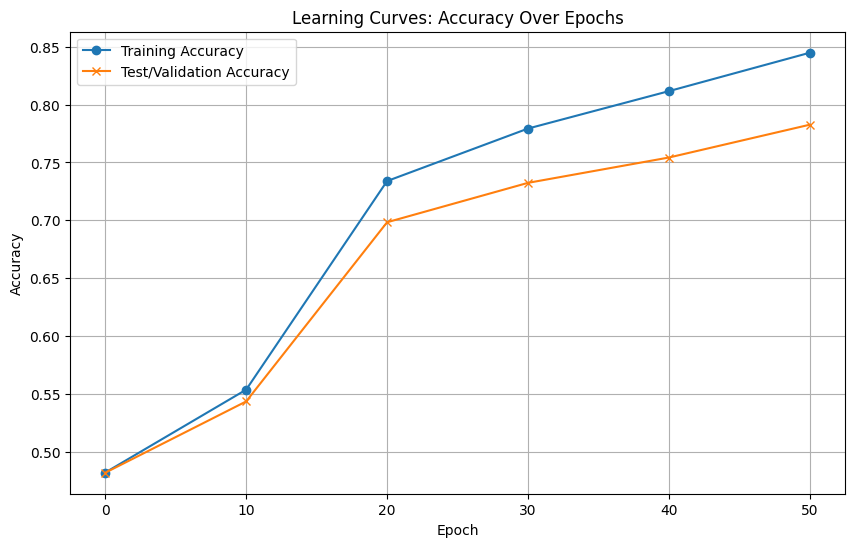


Training Complete. Final Train Acc: 0.8449, Final Test Acc: 0.7826


In [143]:
model = alexnet()
trainacc, valacc = train_CNN(model, combined_train_loader, val_loader, device=torch.device("cuda"), num_epochs=50)
padding_accuracies["Zero padding"] = (trainacc, valacc)

In [144]:
class alexnet_replicatepadding(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=7, stride=2, padding=5, padding_mode='replicate'),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(2)
            )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 10: Train Acc = 0.5313, Test Acc = 0.5434
Epoch 20: Train Acc = 0.7353, Test Acc = 0.6845
Epoch 30: Train Acc = 0.7927, Test Acc = 0.7486
Epoch 40: Train Acc = 0.7990, Test Acc = 0.7486
Epoch 50: Train Acc = 0.8464, Test Acc = 0.7721


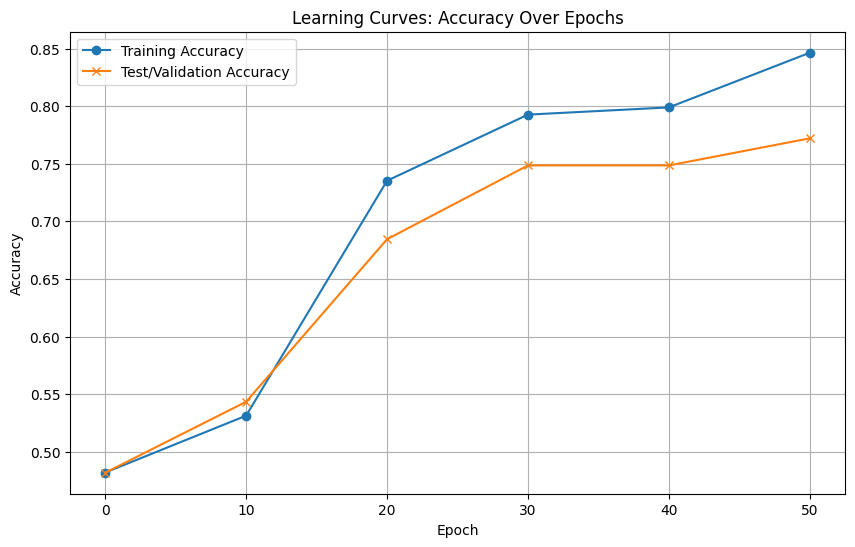


Training Complete. Final Train Acc: 0.8464, Final Test Acc: 0.7721


In [145]:
model = alexnet_replicatepadding()
trainacc, valacc = train_CNN(model, combined_train_loader, val_loader, device=torch.device("cuda"), num_epochs=50)
padding_accuracies["Replicate padding"] = (trainacc, valacc)

In [146]:
class alexnet_reflectpadding(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=7, stride=2, padding=5, padding_mode='reflect'),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(2)
            )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

Epoch 0 (Initial): Train Acc = 0.5181, Test Acc = 0.5182
Epoch 10: Train Acc = 0.5490, Test Acc = 0.5596
Epoch 20: Train Acc = 0.7343, Test Acc = 0.6967
Epoch 30: Train Acc = 0.7490, Test Acc = 0.7234
Epoch 40: Train Acc = 0.8294, Test Acc = 0.7672
Epoch 50: Train Acc = 0.8628, Test Acc = 0.7770


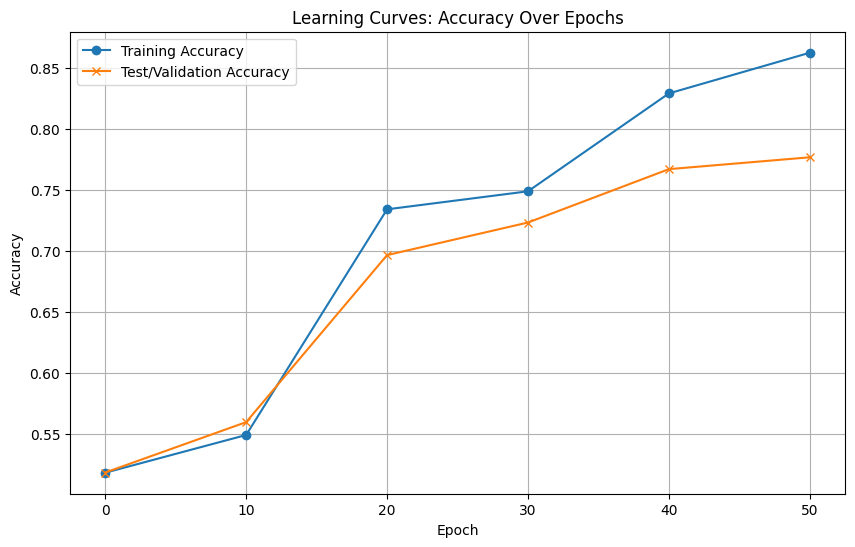


Training Complete. Final Train Acc: 0.8628, Final Test Acc: 0.7770


In [163]:
model = alexnet_reflectpadding()
trainacc, valacc = train_CNN(model, combined_train_loader, val_loader, device=torch.device("cuda"), num_epochs=50)
padding_accuracies["Reflect padding"] = (trainacc, valacc)

In [156]:
class alexnet_60x60(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=7, stride=2, padding=0),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(2)
            )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

Epoch 0 (Initial): Train Acc = 0.4963, Test Acc = 0.4907
Epoch 10: Train Acc = 0.5595, Test Acc = 0.5604
Epoch 20: Train Acc = 0.7219, Test Acc = 0.6853
Epoch 30: Train Acc = 0.8026, Test Acc = 0.7413
Epoch 40: Train Acc = 0.8421, Test Acc = 0.7729
Epoch 50: Train Acc = 0.8572, Test Acc = 0.7786


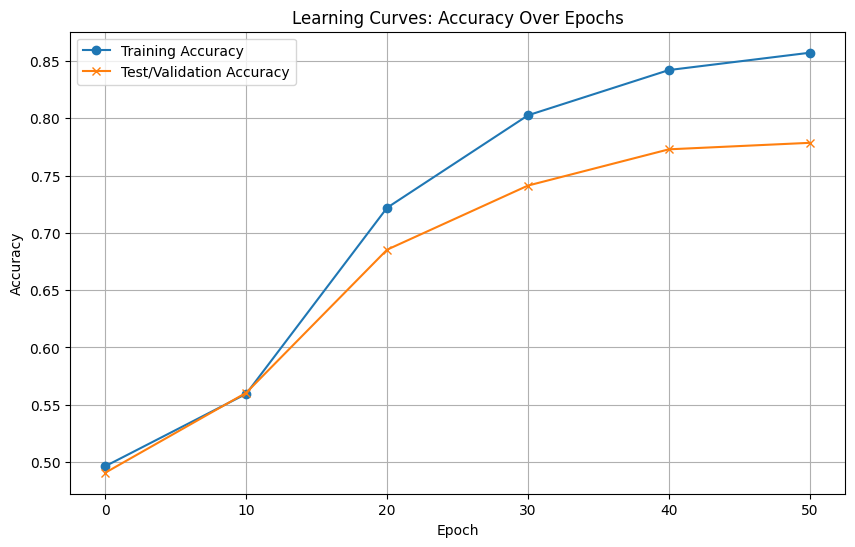


Training Complete. Final Train Acc: 0.8572, Final Test Acc: 0.7786


In [164]:
model = alexnet_60x60()
trainacc, valacc = train_CNN(model, combined_train_loader_60x60, val_loader_60x60, device=torch.device("cuda"), num_epochs=50)
padding_accuracies["Image padding"] = (trainacc, valacc)

In [165]:
padding_accuracies

{'Zero padding': (0.8448695652173913, 0.7826439578264396),
 'Replicate padding': (0.8464347826086956, 0.7721005677210057),
 'Reflect padding': (0.8627826086956522, 0.7769667477696675),
 'Image padding': (0.8572173913043478, 0.7785888077858881)}

padding_mode_performance_bar_chart.png


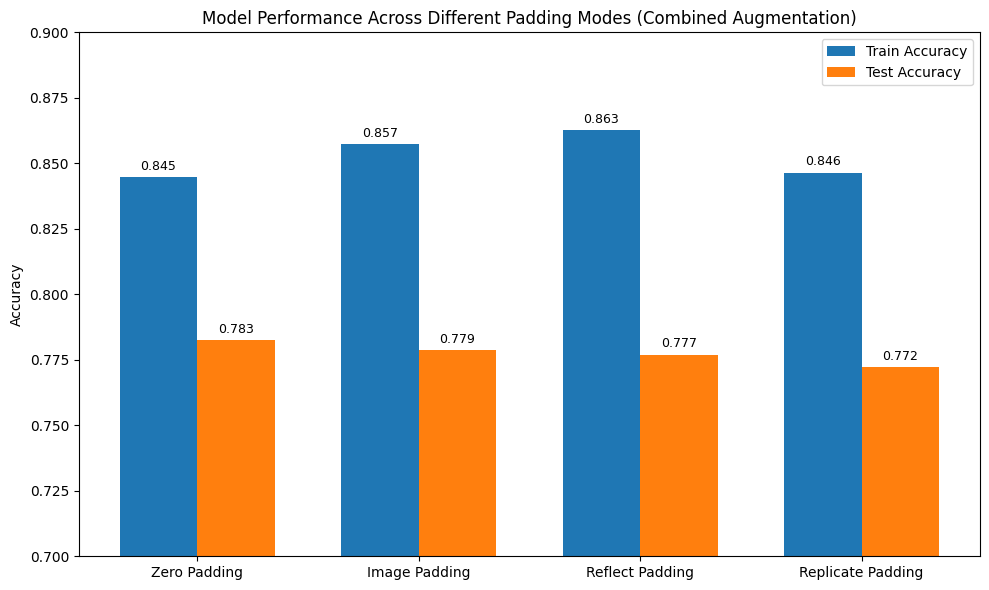

In [166]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data provided by the user
results = padding_accuracies

# 1. Load data into DataFrame
df = pd.DataFrame(results).T.reset_index()
df.columns = ['Padding Mode', 'Train Accuracy', 'Test Accuracy']

# Standardize Augmentation Names for Plotting
df['Padding Mode'] = df['Padding Mode'].str.replace('_', ' ').str.title()

# 2. Sort the DataFrame by Test Accuracy
df = df.sort_values(by='Test Accuracy', ascending=False)

# 3. Setup for Grouped Bar Chart
labels = df['Padding Mode']
train_acc = df['Train Accuracy']
test_acc = df['Test Accuracy']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# 4. Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, train_acc, width, label='Train Accuracy', color='#1f77b4')
rects2 = ax.bar(x + width/2, test_acc, width, label='Test Accuracy', color='#ff7f0e')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance Across Different Padding Modes (Combined Augmentation)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0) # Keep rotation 0 as names are short
ax.legend()
ax.set_ylim(0.7, 0.9) # Set a reasonable y-limit for better visual comparison

# Function to add labels on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig('padding_mode_performance_bar_chart.png')
print("padding_mode_performance_bar_chart.png")

In [180]:
from torch.nn import functional as F
class ResNeXtBlock(nn.Module):
    """The ResNeXt block."""
    def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False,
                 strides=1):
        super().__init__()
        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1)
        self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3,
                                   stride=strides, padding=1,
                                   groups=bot_channels//groups)
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()
        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
            self.bn4 = nn.LazyBatchNorm2d()
        else:
            self.conv4 = None

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        return F.relu(Y + X)

In [189]:
class AnyNet(nn.Module):
    def __init__(self, arch, stem_channels, lr=0.1, num_classes=2):
        super(AnyNet, self).__init__()
        self.net = nn.Sequential(self.stem(stem_channels))
        for i, s in enumerate(arch):
            self.net.add_module(f'stage{i+1}', self.stage(*s))
        self.net.add_module('head', nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.LazyLinear(num_classes)))
        self.net.apply(init_weights)

    def stem(self, num_channels):
        return nn.Sequential(
            nn.LazyConv2d(num_channels, kernel_size=3, stride=2, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU())

    def stage(self, depth, num_channels, groups, bot_mul):
        blk = []
        for i in range(depth):
            if i == 0:
                blk.append(ResNeXtBlock(num_channels, groups, bot_mul,
                    use_1x1conv=True, strides=2))
            else:
                blk.append(ResNeXtBlock(num_channels, groups, bot_mul))
        return nn.Sequential(*blk)

    def forward(self, X):
        """
        Defines the computation performed at every call (forward pass) of the model.
        """
        return self.net(X) # Pass the input X through the Sequential network

In [190]:
class RegNetX32(AnyNet):
    def __init__(self, lr=0.1, num_classes=2):
        stem_channels, groups, bot_mul = 32, 16, 1
        depths, channels = (4, 6), (32, 80)
        super().__init__(
            ((depths[0], channels[0], groups, bot_mul),
             (depths[1], channels[1], groups, bot_mul)),
            stem_channels, lr, num_classes)

In [191]:
accuracies_regnet = {}

Epoch 0 (Initial): Train Acc = 0.5181, Test Acc = 0.5182
Epoch 10: Train Acc = 0.7591, Test Acc = 0.7461
Epoch 20: Train Acc = 0.7894, Test Acc = 0.7664
Epoch 30: Train Acc = 0.7970, Test Acc = 0.7518
Epoch 40: Train Acc = 0.8125, Test Acc = 0.7518
Epoch 50: Train Acc = 0.8687, Test Acc = 0.7729


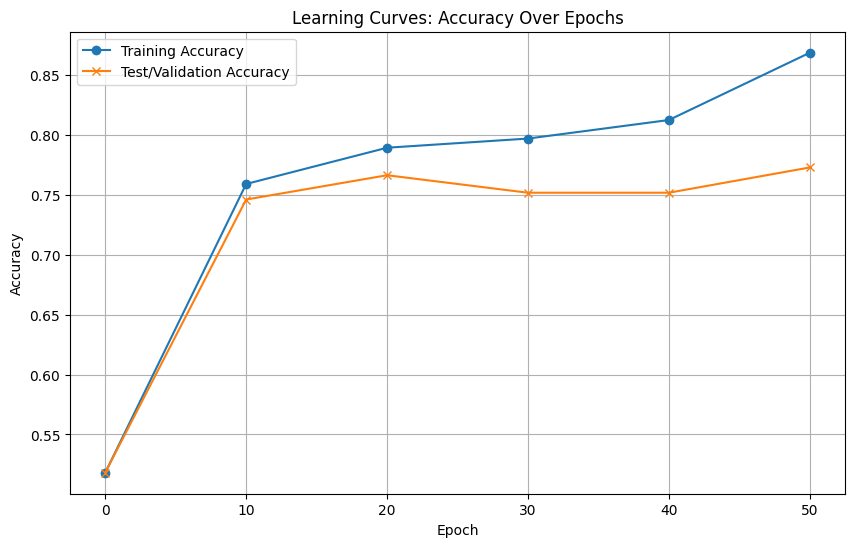


Training Complete. Final Train Acc: 0.8687, Final Test Acc: 0.7729


In [192]:
model = RegNetX32(lr=0.05)
trainacc, valacc = train_CNN(model, combined_train_loader, val_loader, device=torch.device("cuda"), num_epochs=50)
accuracies_regnet["RegNetX32"] = (trainacc, valacc)

In [198]:
class RegNet_any(AnyNet):
    def __init__(self, lr=0.1, num_classes=2,
                 depths: tuple = (4, 6, 12, 8),
                 channels: tuple = (32, 80, 160, 320),
                 stem_channels: int = 32,
                 groups: int = 16,
                 bot_mul: float = 1.0):

        # --- 1. Check for consistency ---
        if len(depths) != len(channels):
            raise ValueError("The 'depths' tuple and 'channels' tuple must have the same length (number of stages).")

        arch = [
            (D, C, groups, bot_mul)
            for D, C in zip(depths, channels)
        ]

        super().__init__(
            arch,
            stem_channels,
            lr,
            num_classes
        )

In [203]:
def count_parameters(model):
    """
    Counts and returns the total number of trainable and non-trainable parameters
    in a PyTorch model.
    """
    total_params = 0
    trainable_params = 0

    # Iterate through all named parameters in the model
    for name, parameter in model.named_parameters():
        # Check if the parameter has an assigned size (it exists)
        if parameter.requires_grad:
            trainable_params += parameter.numel()

        total_params += parameter.numel()

    # Note: Non-trainable parameters are typically buffers (like running_mean
    # and running_var in BatchNorm) and parameters with requires_grad=False.
    # The count_parameters method above only counts actual parameters (nn.Parameter objects).

    return {
        "Total Parameters": f"{total_params:,}",
        "Trainable Parameters": f"{trainable_params:,}",
        "Non-Trainable Parameters": f"{total_params - trainable_params:,}"
    }

# Example Usage:
# model = RegNet_any(...)
# print(count_parameters(model))

In [205]:
stem_channel_accs = {}

In [204]:
count_parameters(model)

{'Total Parameters': '182,226',
 'Trainable Parameters': '182,226',
 'Non-Trainable Parameters': '0'}

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0 (Initial): Train Acc = 0.5181, Test Acc = 0.5182
Epoch 10: Train Acc = 0.7581, Test Acc = 0.7567


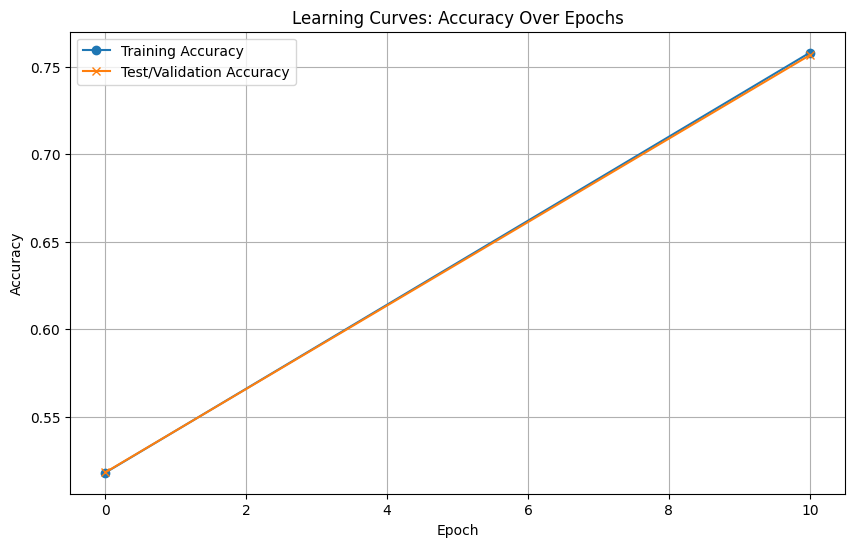


Training Complete. Final Train Acc: 0.7581, Final Test Acc: 0.7567
Epoch 0 (Initial): Train Acc = 0.5181, Test Acc = 0.5182
Epoch 10: Train Acc = 0.7701, Test Acc = 0.7397


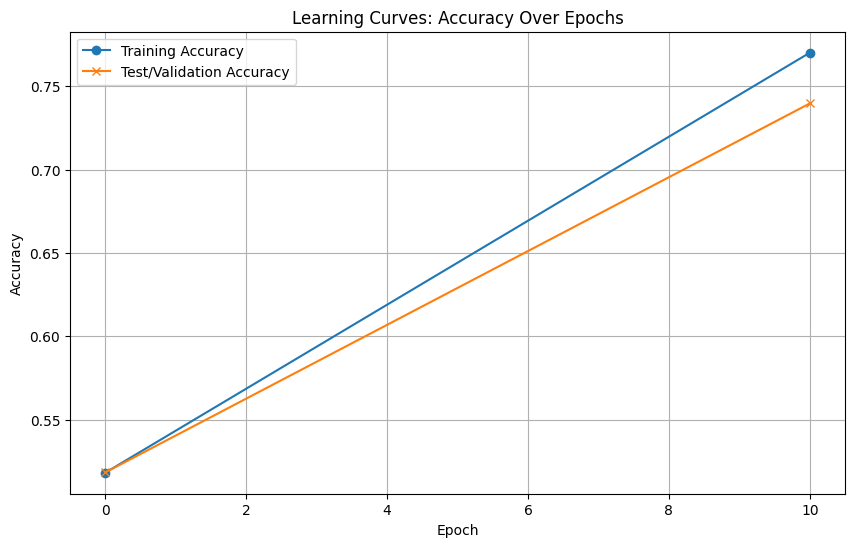


Training Complete. Final Train Acc: 0.7701, Final Test Acc: 0.7397
Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 10: Train Acc = 0.7033, Test Acc = 0.7153


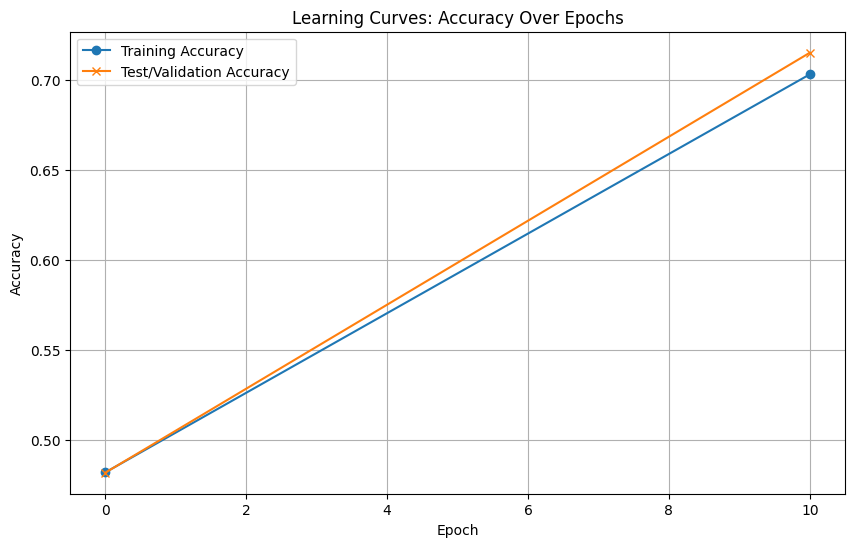


Training Complete. Final Train Acc: 0.7033, Final Test Acc: 0.7153
Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 10: Train Acc = 0.7475, Test Acc = 0.7397


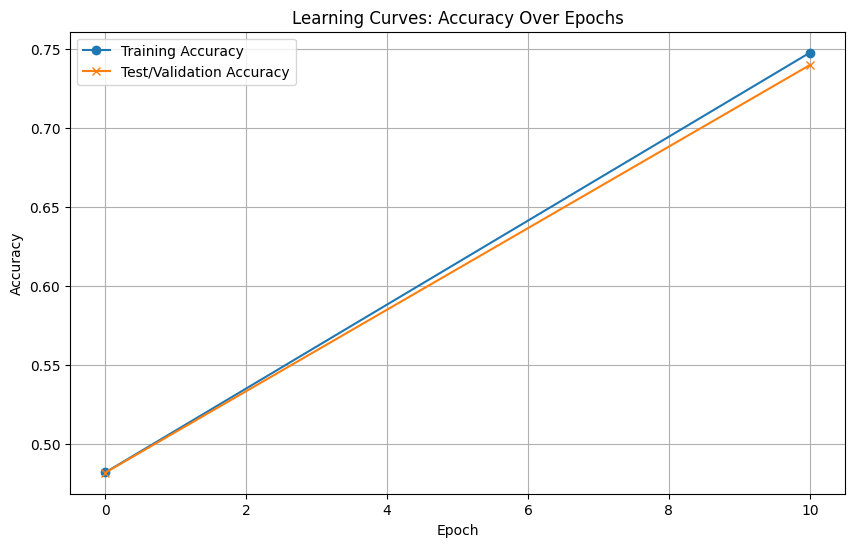


Training Complete. Final Train Acc: 0.7475, Final Test Acc: 0.7397


In [206]:
stem_channels = [8,16,32,64]
for s in stem_channels:
  model = RegNet_any(
    depths=(4, 6),
    channels=(32, 80),
    groups=16,
    bot_mul=1.0,
    stem_channels = s
  )
  trainacc, valacc = train_CNN(model, combined_train_loader, val_loader, device=torch.device("cuda"), num_epochs=10)
  parameters = count_parameters(model)['Trainable Parameters']
  stem_channel_accs[s] = (trainacc, valacc, parameters)

In [207]:
stem_channel_accs

{8: (0.7580869565217392, 0.7566909975669099, '176,962'),
 16: (0.7700869565217391, 0.7396593673965937, '177,714'),
 32: (0.703304347826087, 0.7153284671532847, '179,218'),
 64: (0.7474782608695653, 0.7396593673965937, '182,226')}

reusable_accuracy_vs_percentage_increase.png


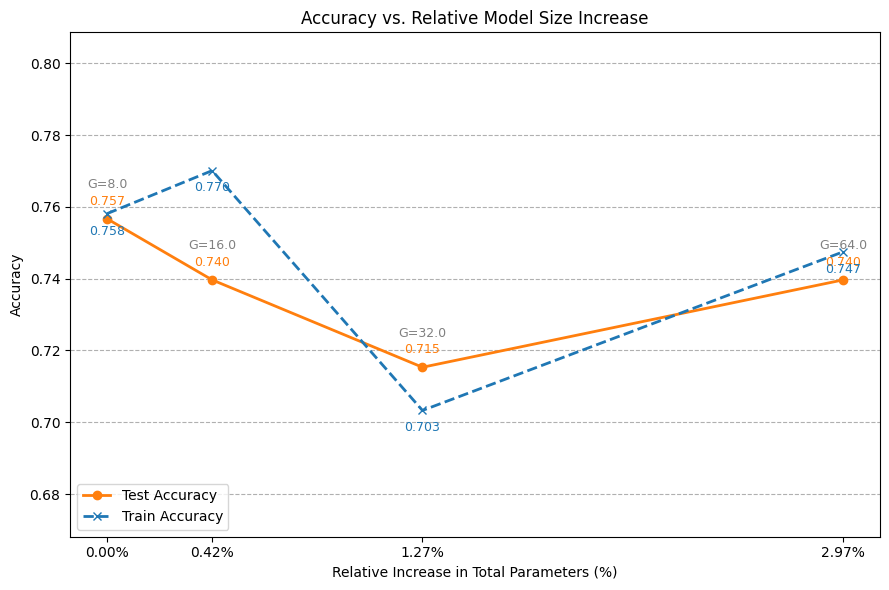

In [219]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Tuple, Union

def plot_accuracy_vs_relative_params(results_dict: Dict[Union[int, str], Tuple[float, float, str]]):
    """
    Generates a line plot showing Train/Test Accuracy vs. the Percentage Increase
    in Total Parameters, relative to the smallest model in the results.

    Args:
        results_dict: A dictionary where keys are the control variable (e.g., Group Width G)
                      and values are tuples (train_acc, test_acc, 'param_count_string').
        filename: The name of the file to save the plot to.
    """

    # 1. Prepare data for DataFrame
    data = []
    for key, values in results_dict.items():
        try:
            # Convert parameter count string to integer
            param_count = int(values[2].replace(',', ''))
        except (ValueError, IndexError):
            print(f"Error processing parameters for key {key}. Value: {values}")
            continue

        data.append({
            'G': key,
            'Train Accuracy': values[0],
            'Test Accuracy': values[1],
            'Total Parameters': param_count
        })

    if not data:
        print("No valid data found to plot.")
        return

    df = pd.DataFrame(data)

    # 2. Calculate the Percentage Increase in Parameters (from the smallest model)
    min_params = df['Total Parameters'].min()
    df['Relative Parameter Increase (%)'] = ((df['Total Parameters'] - min_params) / min_params) * 100

    # Sort by Relative Increase for a clean X-axis
    df_relative = df.sort_values(by='Relative Parameter Increase (%)').reset_index(drop=True)

    # --- PLOT: Test Accuracy vs. Relative Parameter Increase (%) ---

    fig, ax = plt.subplots(figsize=(9, 6))

    # Plot Test Accuracy
    ax.plot(df_relative['Relative Parameter Increase (%)'], df_relative['Test Accuracy'],
            marker='o', linestyle='-', color='#ff7f0e', label='Test Accuracy', linewidth=2)

    # Plot Train Accuracy
    ax.plot(df_relative['Relative Parameter Increase (%)'], df_relative['Train Accuracy'],
            marker='x', linestyle='--', color='#1f77b4', label='Train Accuracy', linewidth=2)

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Relative Increase in Total Parameters (%)')
    ax.set_title('Accuracy vs. Relative Model Size Increase')
    ax.legend(loc='lower left')
    ax.set_ylim(df_relative[['Train Accuracy', 'Test Accuracy']].min().min() * 0.95,
                df_relative[['Train Accuracy', 'Test Accuracy']].max().max() * 1.05) # Dynamic Y-lim
    ax.grid(axis='y', linestyle='--')

    # Set X-ticks to the actual percentage values
    ax.set_xticks(df_relative['Relative Parameter Increase (%)'])
    ax.set_xticklabels([f'{x:.2f}%' for x in df_relative['Relative Parameter Increase (%)']])

    # Add data labels
    def autolabel_percentage(df_row, ax, offset_y_test=10, offset_y_train=-15):
        # Test Accuracy Label (Above point)
        ax.annotate(f'{df_row["Test Accuracy"]:.3f}',
                    (df_row['Relative Parameter Increase (%)'], df_row['Test Accuracy']),
                    textcoords="offset points", xytext=(0, offset_y_test), ha='center', fontsize=9, color='#ff7f0e')
        # Train Accuracy Label (Below point)
        ax.annotate(f'{df_row["Train Accuracy"]:.3f}',
                    (df_row['Relative Parameter Increase (%)'], df_row['Train Accuracy']),
                    textcoords="offset points", xytext=(0, offset_y_train), ha='center', fontsize=9, color='#1f77b4')
        # Label the corresponding Group Width (G)
        ax.annotate(f'G={df_row["G"]}',
                    (df_row['Relative Parameter Increase (%)'], df_row['Test Accuracy']),
                    textcoords="offset points", xytext=(0, offset_y_test + 12), ha='center', fontsize=9, color='gray')


    for _, row in df_relative.iterrows():
        autolabel_percentage(row, ax)

    fig.tight_layout()

# Sample data from previous runs to demonstrate the function
sample_results = {
    8: (0.7580869565217392, 0.7566909975669099, '176,962'),
    16: (0.7700869565217391, 0.7396593673965937, '177,714'),
    32: (0.703304347826087, 0.7153284671532847, '179,218'),
    64: (0.7474782608695653, 0.7396593673965937, '182,226')
}

# Execute the function with sample data
plot_accuracy_vs_relative_params(sample_results, filename='reusable_accuracy_vs_percentage_increase.png')

acc_vs_percentage_parameter_increase.png


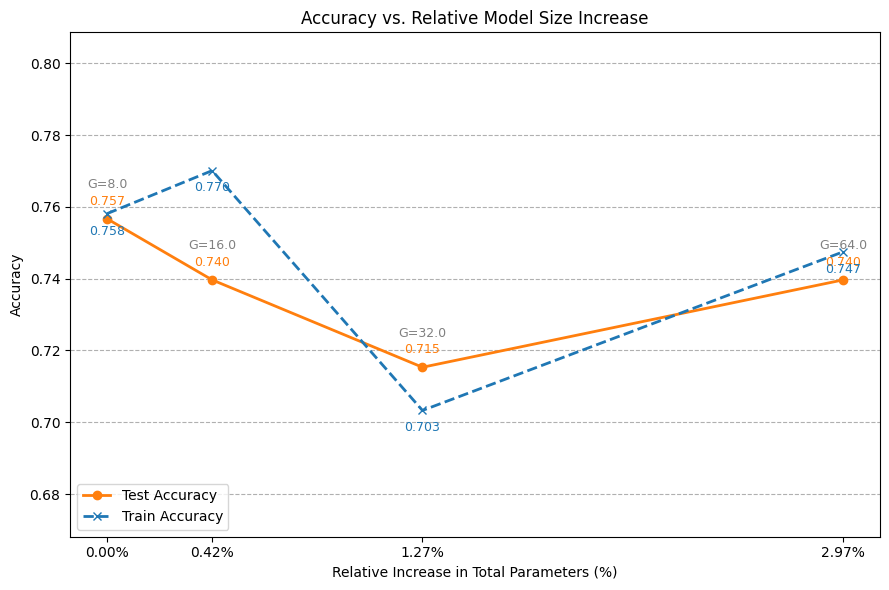

In [220]:
plot_accuracy_vs_relative_params(stem_channel_accs)

In [210]:
last_depths_accs={}

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0 (Initial): Train Acc = 0.5181, Test Acc = 0.5182
Epoch 10: Train Acc = 0.7317, Test Acc = 0.7056


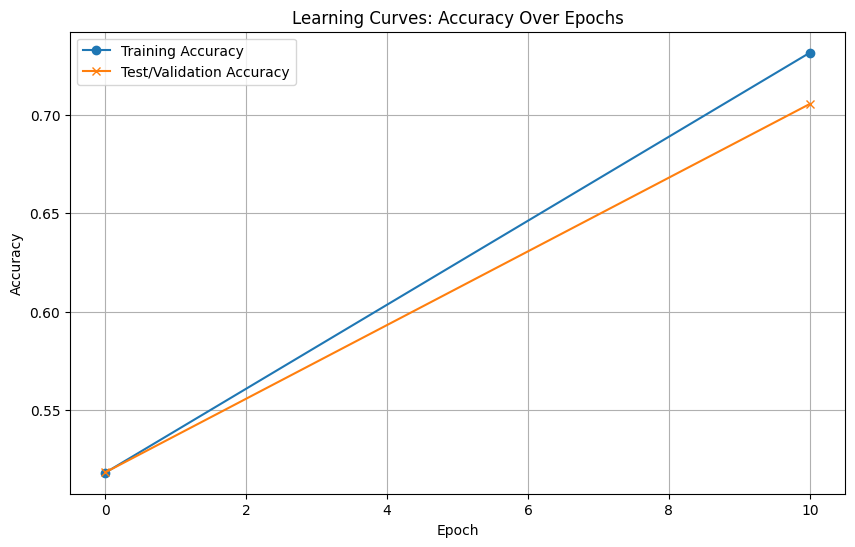


Training Complete. Final Train Acc: 0.7317, Final Test Acc: 0.7056
Epoch 0 (Initial): Train Acc = 0.5181, Test Acc = 0.5182
Epoch 10: Train Acc = 0.7057, Test Acc = 0.7048


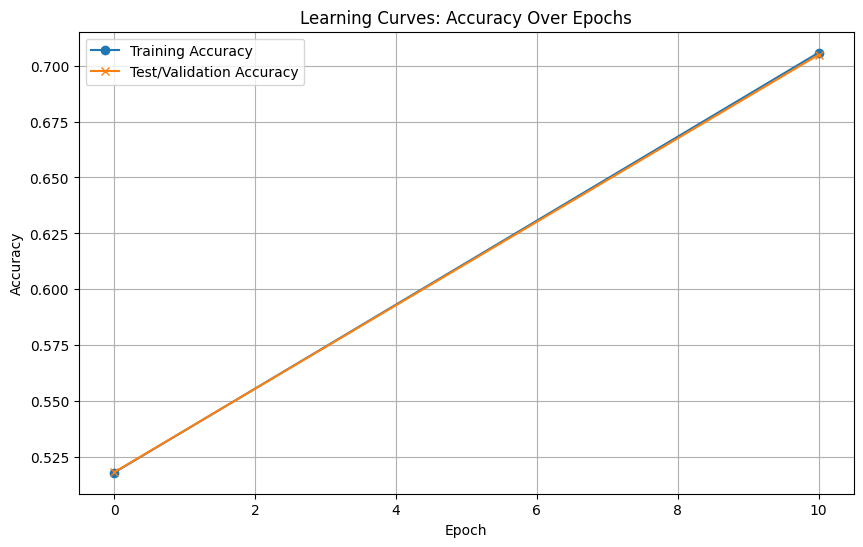


Training Complete. Final Train Acc: 0.7057, Final Test Acc: 0.7048
Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79428d10de40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79428d10de40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 10: Train Acc = 0.7024, Test Acc = 0.7202


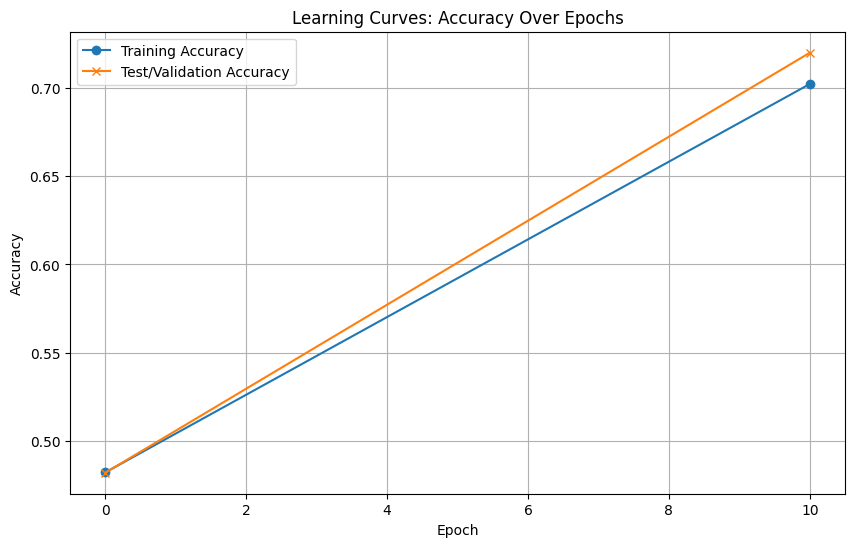


Training Complete. Final Train Acc: 0.7024, Final Test Acc: 0.7202
Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 10: Train Acc = 0.7137, Test Acc = 0.7380


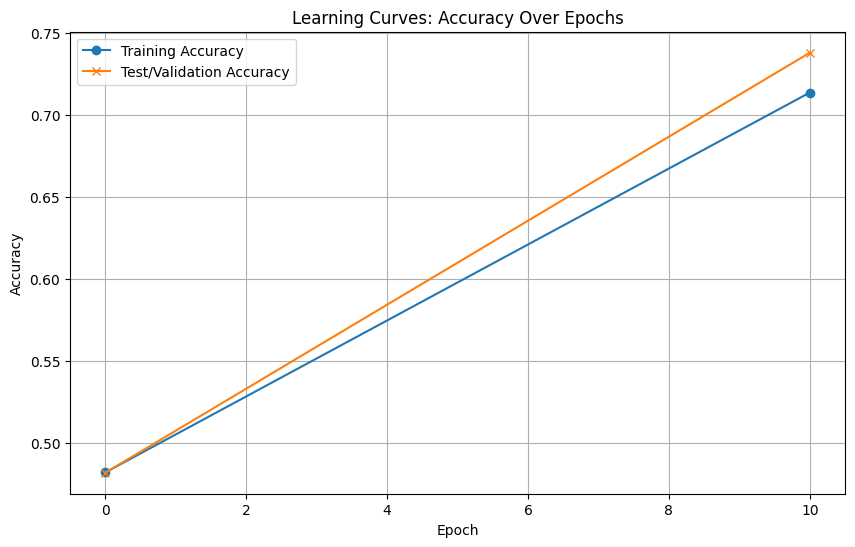


Training Complete. Final Train Acc: 0.7137, Final Test Acc: 0.7380


In [211]:
last_depths = [8,16,32,64]
for l in last_depths:
  model = RegNet_any(
    depths=(4, l),
    channels=(32, 80),
    groups=16,
    bot_mul=1.0,
    stem_channels = 8
  )
  trainacc, valacc = train_CNN(model, combined_train_loader, val_loader, device=torch.device("cuda"), num_epochs=10)
  parameters = count_parameters(model)['Trainable Parameters']
  last_depths_accs[l] = (trainacc, valacc, parameters)

In [212]:
last_depths_accs

{8: (0.7316521739130435, 0.7055961070559611, '227,042'),
 16: (0.7057391304347826, 0.7047850770478508, '427,362'),
 32: (0.7024347826086956, 0.7201946472019465, '828,002'),
 64: (0.7137391304347827, 0.7380373073803731, '1,629,282')}

acc_vs_percentage_parameter_increase.png


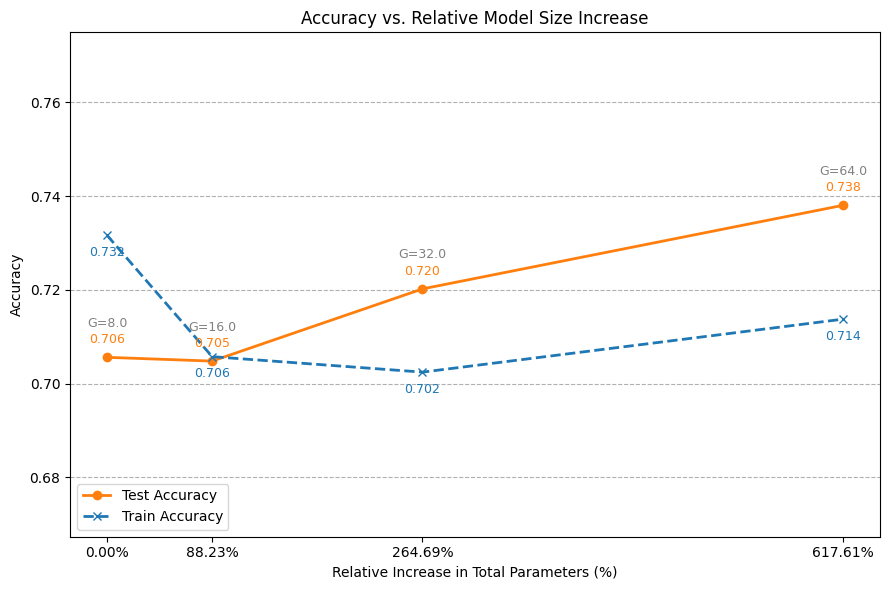

In [221]:
plot_accuracy_vs_relative_params(last_depths_accs)

In [216]:
first_depths_accs= {}

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 10: Train Acc = 0.7238, Test Acc = 0.7178


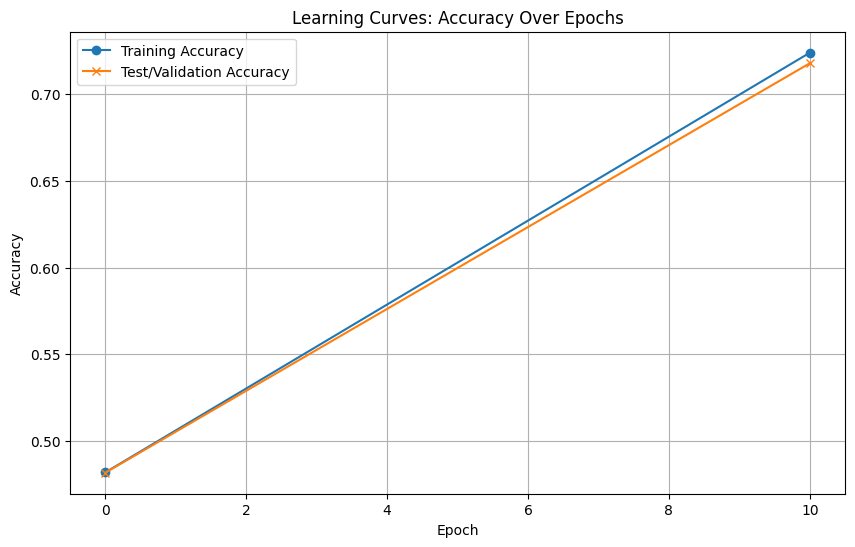


Training Complete. Final Train Acc: 0.7238, Final Test Acc: 0.7178
Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 10: Train Acc = 0.5193, Test Acc = 0.5182


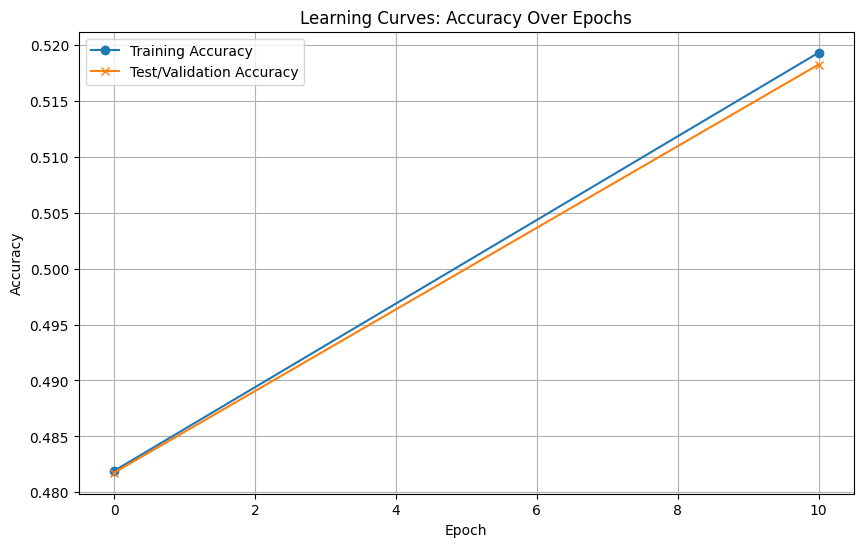


Training Complete. Final Train Acc: 0.5193, Final Test Acc: 0.5182
Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 10: Train Acc = 0.7198, Test Acc = 0.7218


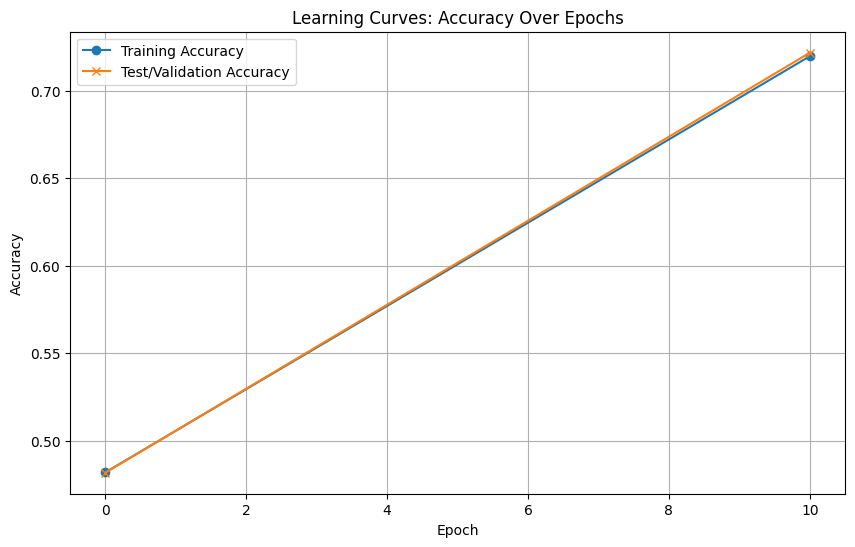


Training Complete. Final Train Acc: 0.7198, Final Test Acc: 0.7218
Epoch 0 (Initial): Train Acc = 0.5181, Test Acc = 0.5182
Epoch 10: Train Acc = 0.7296, Test Acc = 0.7388


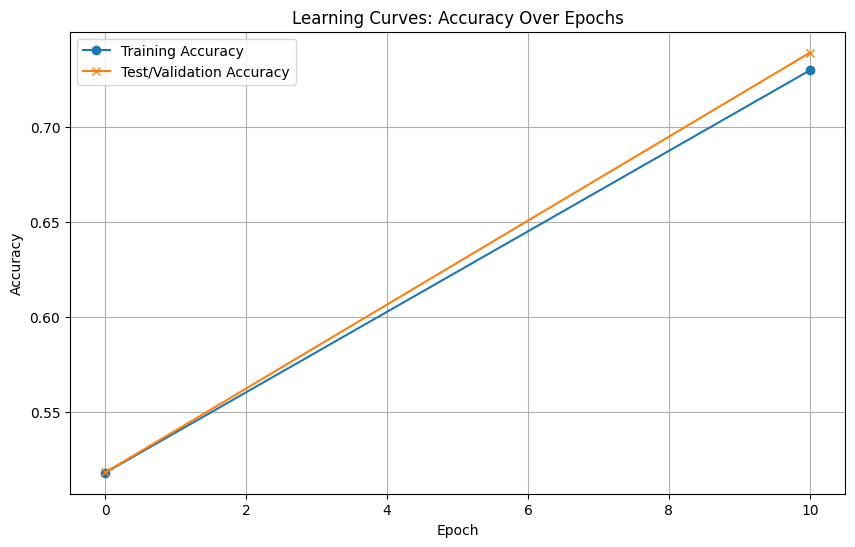


Training Complete. Final Train Acc: 0.7296, Final Test Acc: 0.7388


In [217]:
last_depths = [8,16,32,64]
for l in last_depths:
  model = RegNet_any(
    depths=(l, 8),
    channels=(32, 80),
    groups=16,
    bot_mul=1.0,
    stem_channels = 8
  )
  trainacc, valacc = train_CNN(model, combined_train_loader, val_loader, device=torch.device("cuda"), num_epochs=10)
  parameters = count_parameters(model)['Trainable Parameters']
  first_depths_accs[l] = (trainacc, valacc, parameters)

acc_vs_percentage_parameter_increase.png


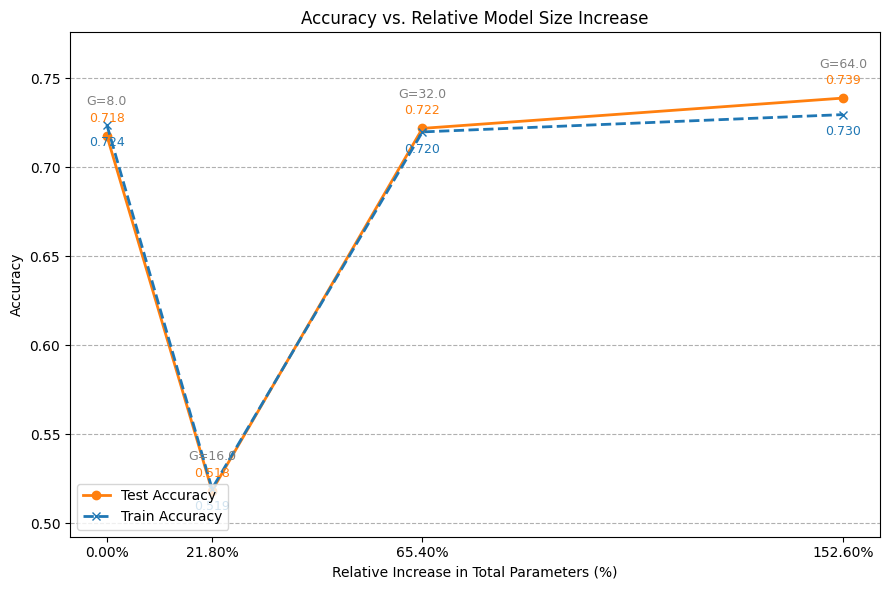

In [222]:
plot_accuracy_vs_relative_params(first_depths_accs)

In [226]:
channel_size_accs = {}

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0 (Initial): Train Acc = 0.5181, Test Acc = 0.5182
Epoch 5: Train Acc = 0.6344, Test Acc = 0.6610


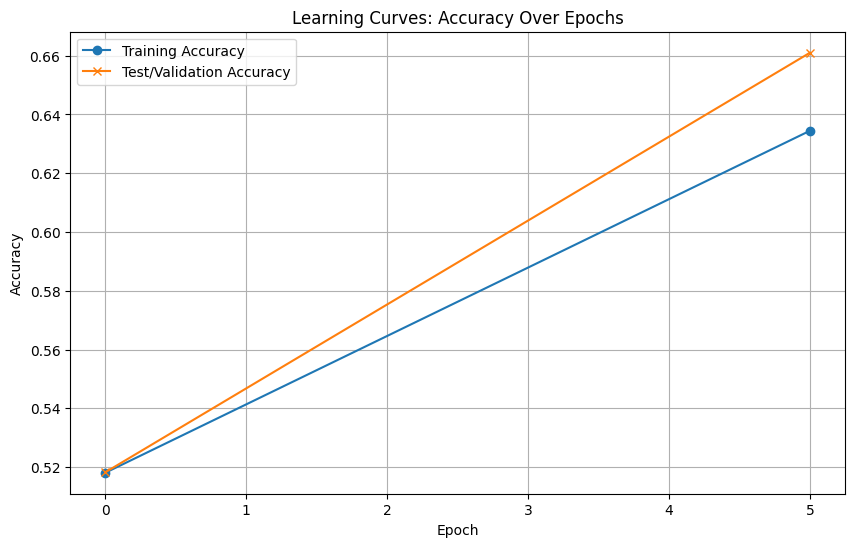


Training Complete. Final Train Acc: 0.6344, Final Test Acc: 0.6610
Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 5: Train Acc = 0.6012, Test Acc = 0.6277


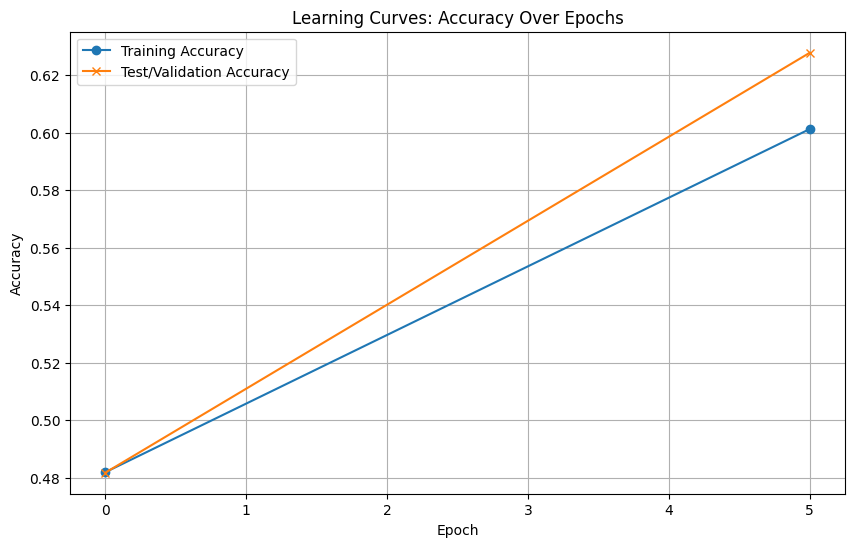


Training Complete. Final Train Acc: 0.6012, Final Test Acc: 0.6277


In [ ]:
channel_ratio = [1,2,4,8,16]
channel_mag = [16, 32, 64, 128, 256]
for c in channel_ratio:
  for m in channel_mag:
    model = RegNet_any(
      depths=(8, 32),
      channels=(m, c*m),
      groups=16,
      bot_mul=1.0,
      stem_channels = 8
    )
    trainacc, valacc = train_CNN(model, combined_train_loader, val_loader, device=torch.device("cuda"), num_epochs=5)
    parameters = count_parameters(model)['Trainable Parameters']
    channel_size_accs[(c,m)] = (trainacc, valacc, parameters)